In [2]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")




## Setting up and creating dataframe for analysis


In [53]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

### setting up connection to mongo

In [54]:
#### set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
key  = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['semantic_parts']
coll = db['sketchpad_basic']

# which iteration name should we use?
iterationName = 'pilot0'

In [55]:
num_sketches = coll.find({'iterationName':iterationName}).count()
print 'We have {} annotations so far.'.format(num_sketches)

We have 207 annotations so far.


In [56]:
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
kmukherjee = ['A1WU4IHJNQGVAY']
researchers = jefan + hawkrobe  + kmukherjee

In [57]:
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')
print 'We have had {} unique sessions'.format( len(unique_assignments))

We have had 24 unique sessions


In [58]:
## get list of unique_assignments
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')

### initialize a bunch of stuff
orig_gameID = [] # the gameID from which this sketch was sourced
orig_trial_num = [] # the trialnum in the original game from which this sketch was sourced -- 
sketch_id = [] # concatenation of orig_gameID and orig_trial_num -- 
assignmentID = [] # the session in which this annotation was collected -- 
annotation_id = [] # the unique ID for each annotation trial (different for each session the same sketch appears in)
category = [] # e.g., "chair"
target = [] # e.g., "inlay"
condition = [] # e.g., "closer" vs. "further" or "repeated" vs. "control
trial_num = [] 
workerID = [] #mTurk workerId
spline_id =[] #unique spline identifier
time_submitted = [] # when the participant clicked "next sketch"
time_labeled = [] # unique to each spline labeled
time_clicked = [] # when this spline was clicked/selected
num_strokes_in_sketch = [] # how many strokes in this sketch
num_splines_in_sketch = [] # how many spline elements in this sketch
stroke_num = [] # which stroke number this labeled spline came from
cumulative_spline_num = [] # spline index in the cumulative spline sequence for the entire sketch
within_stroke_spline_num = [] # spline index for the current stroke
cumulative_bout_num= [] #which bout of annotation the spline belonged to
part_bout_num =[] #which part-specific bout of annotation the spline belonged to
label = [] # the label provided by the participant
spline_svg_string = [] # the svg spline string that earned this label
sketch_svg_string = [] # the entire svg string correponding to this sketch
annotation_flag = [] # this is True if all splines were labeled as the same thing
annotation_spline_id = [] #unique identifier for specific annotation of a spline
png=[] #png string for the annotated sketch
stroke_id=[]

## loop through all the unique assignments that have submitted things
for this_assignment, aID in enumerate(unique_assignments):
    if this_assignment%10==0:
        print 'Analyzing sketches from assignment {} of {}  ...'.format(this_assignment, len(unique_assignments))

    ### get all the sketch recs for this assignment
    sketch_recs = coll.find({'$and': [{'iterationName':iterationName}, {'aID':aID}]}).sort('time')

    try:

        for sketch_ind,sketch in enumerate(sketch_recs):
            ## get annotations embedded within record
            sketch_cat = sketch['category']
            annotations_string = sketch['annotations']
    
            ## convert to json dictionary
            _annotations_dict = json.loads(annotations_string)  
           
            annotations_dict = _annotations_dict[0][sketch_cat]
            png_string = _annotations_dict[0]['png']
            num_splines = len(annotations_dict)
            for annotation in annotations_dict:
                assert sketch['numSplines']==num_splines                
                ## get spline-level metadata
            
                workerID.append(h.encode(key,sketch['wID']))
                label.append(annotation['label'])
                stroke_num.append(annotation['strokeNum'])
                spline_svg_string.append(annotation['svgString'])
                cumulative_spline_num.append(annotation['cumulativeSplineNum'])
                within_stroke_spline_num.append(annotation['withinStrokeSplineNum'])
                time_clicked.append(annotation['timeClicked'])
                time_labeled.append(annotation['timeLabeled'])
                spline_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['cumulativeSplineNum']))
                stroke_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['strokeNum']))
                cumulative_bout_num.append(annotation['boutNum'])
                part_bout_num.append(annotation['partBoutNum'])
                ## get sketch-level metadata
                orig_gameID.append(sketch['originalGameID'])   
                orig_trial_num.append(sketch['originalTrialNum'])
                sketch_id.append('{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum']))
                annotation_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID']))
                assignmentID.append(sketch['aID'])
                category.append(sketch['category'])
                target.append(sketch['target'])
                png.append(png_string)
                condition.append(sketch['condition'])
                time_submitted.append(sketch['time'])
                trial_num.append(sketch['trialNum'])
                num_splines_in_sketch.append(sketch['numSplines'])
                num_strokes_in_sketch.append(sketch['numStrokes'])
                sketch_svg_string.append(sketch['svg'])
                annotation_flag.append(sketch['sameAnnotflag'])
                annotation_spline_id.append('{}_{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID'],annotation['cumulativeSplineNum']))
                
    except AssertionError:
        print 'There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch {} from {}'.\
                format(sketch['trialNum'], sketch['aID'])


Analyzing sketches from assignment 0 of 24  ...
Analyzing sketches from assignment 10 of 24  ...
Analyzing sketches from assignment 20 of 24  ...


In [59]:
## make group dataframe 
D = pd.DataFrame([workerID,orig_gameID, orig_trial_num, sketch_id, category, assignmentID,  target, \
                  annotation_id, condition, trial_num, time_submitted,\
                 time_labeled, time_clicked, num_strokes_in_sketch, num_splines_in_sketch,\
                 stroke_num, cumulative_spline_num, within_stroke_spline_num, cumulative_bout_num,\
                 part_bout_num, label, spline_svg_string, sketch_svg_string, spline_id, stroke_id,\
                  annotation_spline_id,png])
D = D.transpose()
D.columns = ['workerID','orig_gameID', 'orig_trial_num', 'sketch_id', 'category', 'assignmentID', 'target',\
             'annotation_id', 'condition', 'trial_num', 'time_submitted',\
             'time_labeled', 'time_clicked', 'num_strokes_in_sketch', 'num_splines_in_sketch',\
             'stroke_num', 'cumulative_spline_num', 'within_stroke_spline_num', 'cumulative_bout_num', 'part_bout_num', 'label',\
             'spline_svg_string', 'sketch_svg_string', 'spline_id','stroke_id','annotation_spline_id','png']
D=D[D['assignmentID']!='']


print 'Annotations dataframe contains {} rows and {} columns.'.format(D.shape[0],D.shape[1])

Annotations dataframe contains 5029 rows and 27 columns.


In [60]:
##Check to see what dataframe looks like
D.head()

,workerID,orig_gameID,orig_trial_num,sketch_id,category,assignmentID,target,annotation_id,condition,trial_num,...,within_stroke_spline_num,cumulative_bout_num,part_bout_num,label,spline_svg_string,sketch_svg_string,spline_id,stroke_id,annotation_spline_id,png
0,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,closer,0,...,0,0,0,leg,"M70,203c3.83938,0 19,-28.41653 19,-35","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
1,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,closer,0,...,0,0,0,leg,"M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4.9...","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_0,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_0,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
2,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,closer,0,...,0,0,0,leg,"M169,151c13.64771,0 31,35.2618 31,48","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_4,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_3,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
3,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,closer,0,...,0,0,0,leg,"M198,147c0,20.70501 25,28.72755 25,47","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_5,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_4,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
4,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,closer,0,...,0,0,0,leg,"M237,172c-1.50317,0 -2,-19.96898 -2,-22","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_35,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_16,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...


## Visualizations and desriptive statistics 

In [61]:
#Get a count of how many unique sketches have been annotated

unique_sketches = np.unique(D['sketch_id'].values)
print 'We have {} unique sketches.'.format(len(unique_sketches))

We have 207 unique sketches.


Text(0,0.5,'number of sketches')

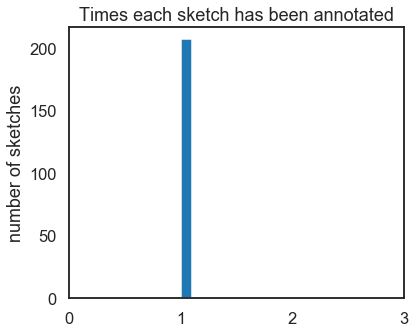

In [62]:
## get number of times each sketch has been annotated
num_times_annotated = []
for this_sketch_id in unique_sketches:
    num_times_annotated.append(D[D['sketch_id']==this_sketch_id]['assignmentID'].nunique())
    
## make a histogram
sns.set_context('talk')
plt.figure(figsize=(6,5))
h = plt.hist(num_times_annotated)
plt.xticks(np.arange(0, 4, step=1))
plt.title('Times each sketch has been annotated')
plt.ylabel('number of sketches')


In [63]:
##Make sure the number of splines for each sketch is consistent across annotations
for this_sketch in unique_sketches:
    assert len(np.unique(D[D['sketch_id']==this_sketch]['num_splines_in_sketch'].values))==1

unique_annotation_trials = np.unique(D['annotation_id'].values)
    

In [64]:
## get annotation time for each annotation trial
annotation_time = []
spline_number_in_sketch = []

for this_annotation_trial in unique_annotation_trials:
    earliest_click = float(np.min(D[D['annotation_id']==this_annotation_trial]['time_clicked']))
    ## all of the splines were submitted at the same time, so time_submitted should be identical for all splines in an annotation trial
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values))==1
    final_submission = np.unique(D[D['annotation_id']==this_annotation_trial]['time_submitted'].values)[0]
    annotation_time.append(final_submission-earliest_click)        
    if np.isnan(final_submission) or np.isnan(earliest_click):
        print 'One of these timestamps is a NaN. Probably means that the participant skipped this trial:'
        print this_annotation_trial
        print 'final_submission: {}, earliest_click: {}'.format(final_submission, earliest_click)
    #### then we will extract how "complex" each sketch i
    assert len(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'].values))==1    
    spline_number_in_sketch.append(np.unique(D[D['annotation_id']==this_annotation_trial]['num_splines_in_sketch'])[0])
    

One of these timestamps is a NaN. Probably means that the participant skipped this trial:
0834-74e58d84-5f2f-4ffd-8df3-e32076ea5aa1_4_3U088ZLJVL7ZB8AS35V4VR2TXUAW0S
final_submission: 1.54239508416e+12, earliest_click: nan
One of these timestamps is a NaN. Probably means that the participant skipped this trial:
1233-33433bd3-d72b-4c2a-9ed0-3e83a80f8e94_4_3U088ZLJVL7ZB8AS35V4VR2TXUAW0S
final_submission: 1.54239509736e+12, earliest_click: nan
One of these timestamps is a NaN. Probably means that the participant skipped this trial:
3485-477008c1-e529-4ad0-a62b-df33c782a5e3_4_3U088ZLJVL7ZB8AS35V4VR2TXUAW0S
final_submission: 1.54239507629e+12, earliest_click: nan
One of these timestamps is a NaN. Probably means that the participant skipped this trial:
3956-be947e80-531d-42ce-b238-e0b3bd997edf_4_3U088ZLJVL7ZB8AS35V4VR2TXUAW0S
final_submission: 1.54239509370e+12, earliest_click: nan
One of these timestamps is a NaN. Probably means that the participant skipped this trial:
4609-852cfd4d-44d8-42f

In [65]:
## convert annotation time to seconds
annotation_time_seconds = np.array(annotation_time)/1000

## make dataframe with annotation time and spline number
unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds = map(list, [unique_annotation_trials, spline_number_in_sketch, annotation_time_seconds])
T = pd.DataFrame([unique_annotation_trials,spline_number_in_sketch,annotation_time_seconds])
T = T.transpose()
T.columns = ['annotation_trial','spline_number_in_sketch','annotation_time']

## some preprocessing of T
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)


## make numeric types
T = h.convert_numeric(T,'spline_number_in_sketch')
T = h.convert_numeric(T,'annotation_time')

## also remove the skipped trial where annotation time is a NaN
T = T[~np.isnan(T['annotation_time'])]

(0, 300)

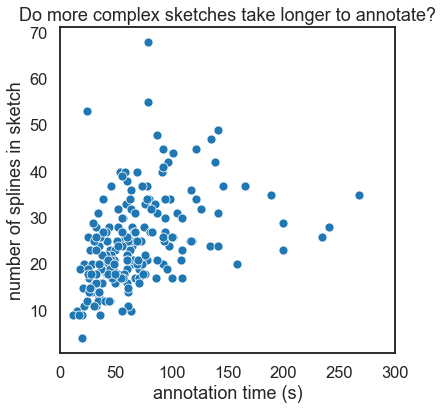

In [66]:
## make scatterplot of relationship between annotation time and spline number
plt.figure(figsize=(6,6))
sns.scatterplot(x='annotation_time',
                y='spline_number_in_sketch',
                data=T)
plt.ylabel('number of splines in sketch')
plt.xlabel('annotation time (s)')
plt.title('Do more complex sketches take longer to annotate?')
plt.xlim(0,60*5) ## 5 minute cutoff ...

In [67]:
r, p = stats.spearmanr(T['annotation_time'],T['spline_number_in_sketch'])
print 'Spearman correlation between annotation time and spline number in sketch' 
print 'r = {}, p = {}'.format(r,p)

Spearman correlation between annotation time and spline number in sketch
r = 0.545815585728, p = 7.61228840607e-17


In [68]:
## get the list of unique labels applied to sketches
unique_labels = np.unique(D.label.values)

## Removing Nones and obviously wrong super long lables
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

print 'we have {} unique labels'.format(len( unique_labels))

we have 47 unique labels


In [69]:
##Get a list of categories
unique_cats = np.unique(D['category'])

##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

In [70]:
##Create vectors that contain the number of part instances in each sketch

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = np.unique(DSA.label.values)
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec
    label_vect_dict[category]= Label_Vec

In [71]:
len(D[D['category']=='dog'])

1239

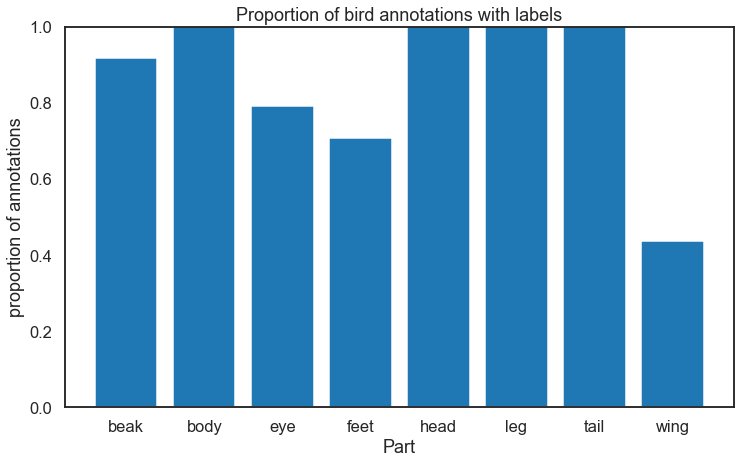

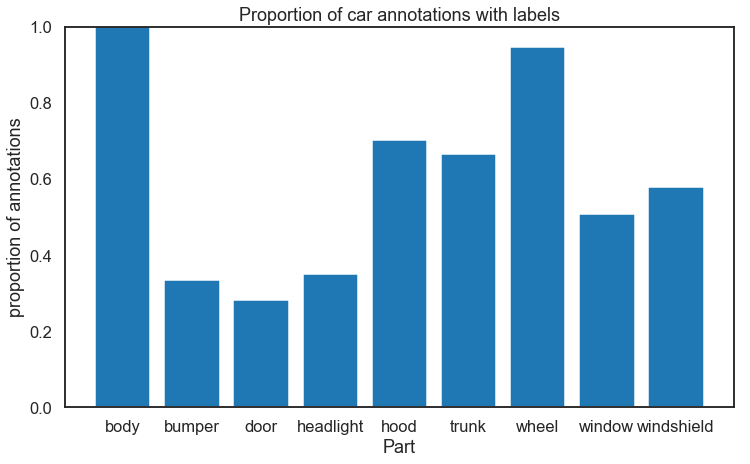

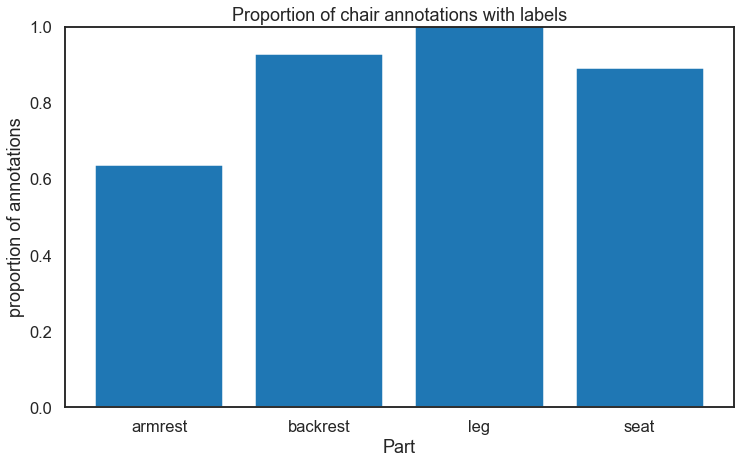

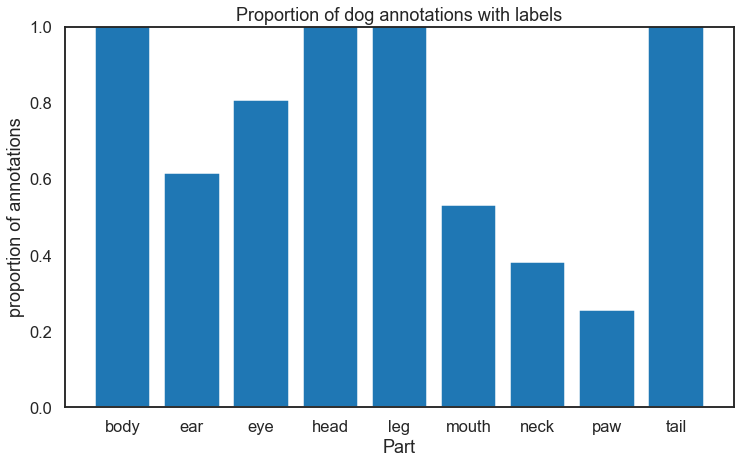

In [72]:
valid_labels=[]
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 10
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        prop_labels.append(D[D['label']==part]['annotation_id'].nunique()/D[D['category']==category]['sketch_id'].nunique())
    
    
    sns.set_context('talk')
    plt.figure(figsize=(12,7))
    plt.ylim(0,1)
    h = plt.bar(plot_labels,prop_labels)
    plt.title('Proportion of {} annotations with labels'.format(category))
    plt.ylabel('proportion of annotations')
    plt.xlabel('Part')

In [73]:
valid_labels = [item for sublist in valid_labels for item in sublist]
valid_labels 

[u'beak',
 u'body',
 u'eye',
 u'feet',
 u'head',
 u'leg',
 u'tail',
 u'wing',
 u'body',
 u'bumper',
 u'door',
 u'headlight',
 u'hood',
 u'trunk',
 u'wheel',
 u'window',
 u'windshield',
 u'armrest',
 u'backrest',
 u'leg',
 u'seat',
 u'body',
 u'ear',
 u'eye',
 u'head',
 u'leg',
 u'mouth',
 u'neck',
 u'paw',
 u'tail']

In [74]:
D=D[D['label'].isin(valid_labels)]
D.shape

(4437, 27)

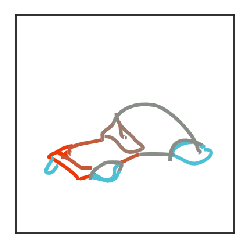

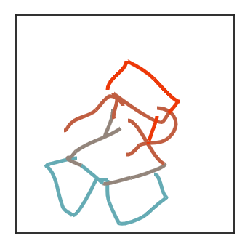

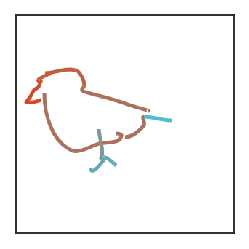

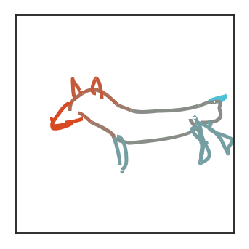

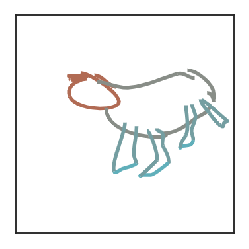

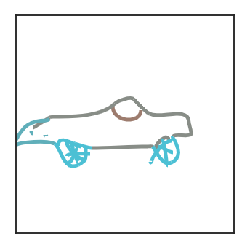

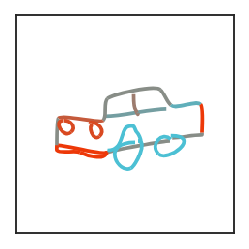

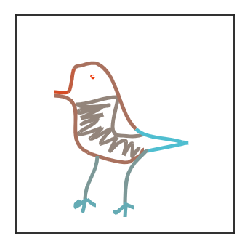

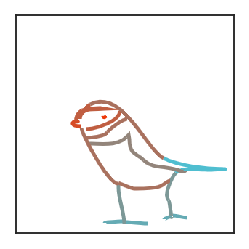

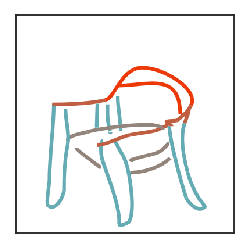

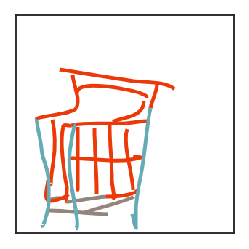

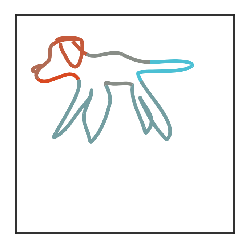

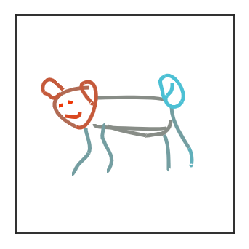

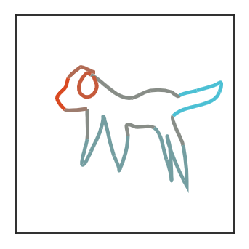

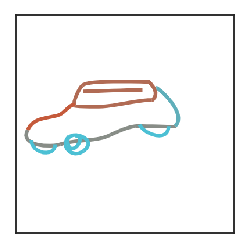

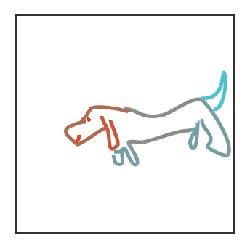

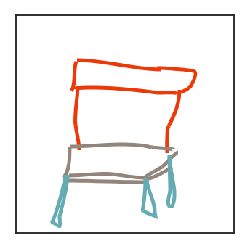

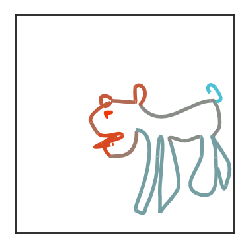

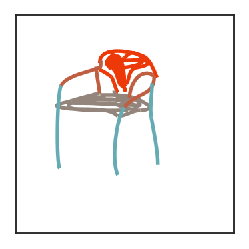

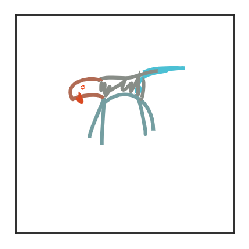

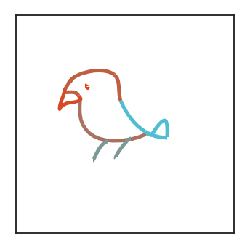

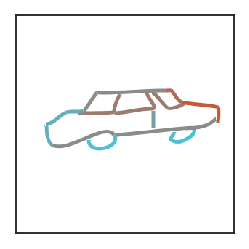

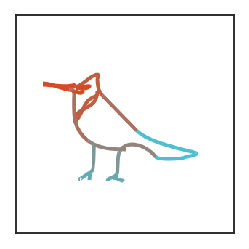

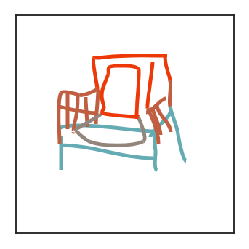

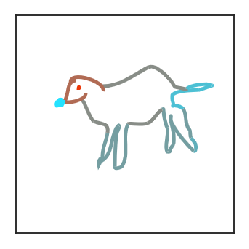

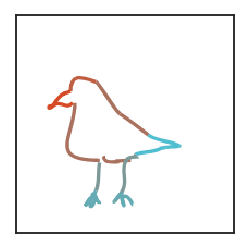

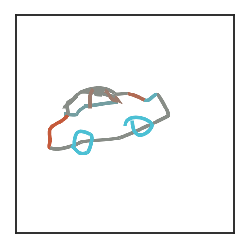

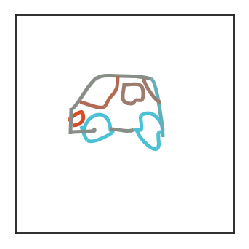

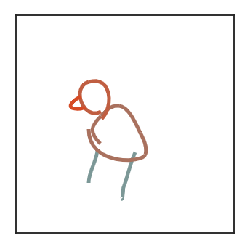

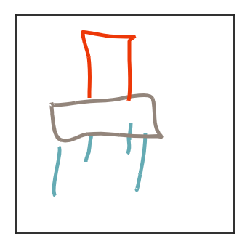

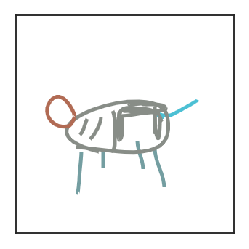

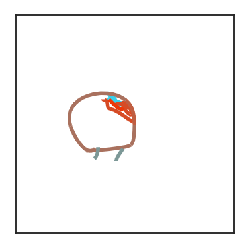

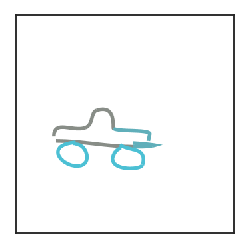

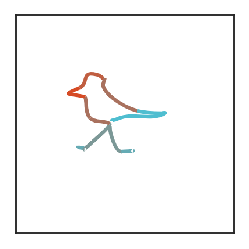

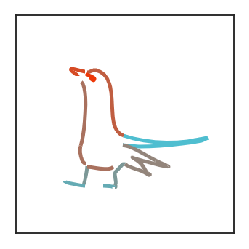

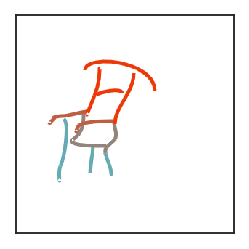

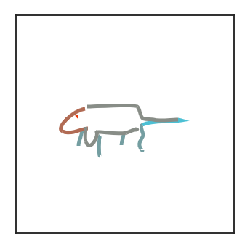

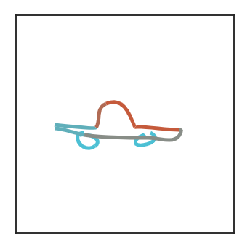

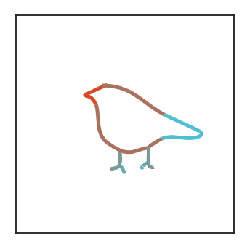

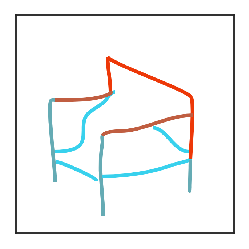

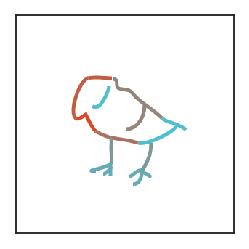

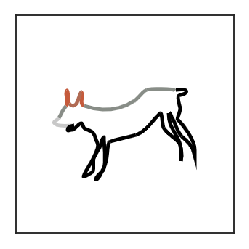

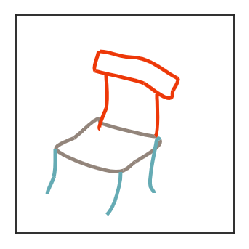

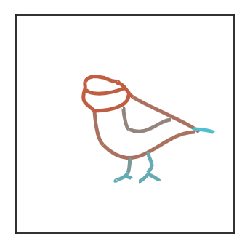

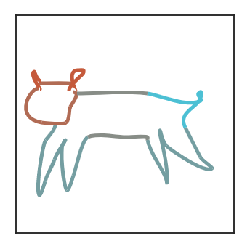

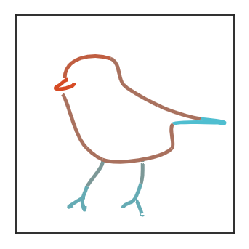

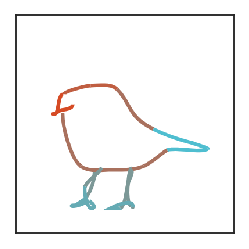

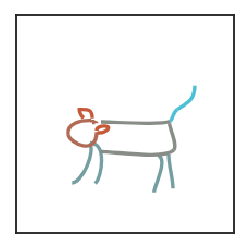

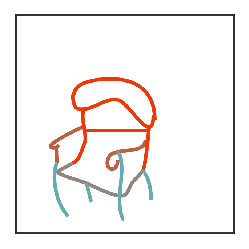

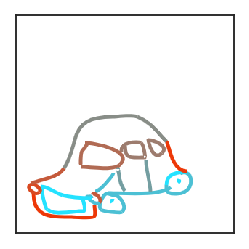

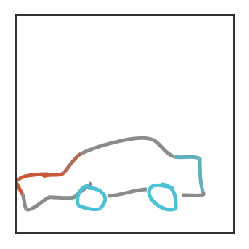

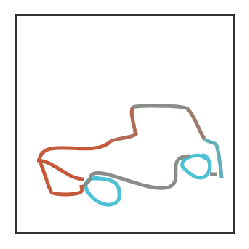

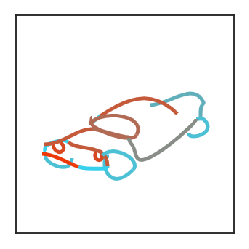

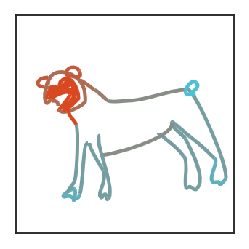

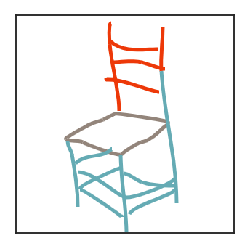

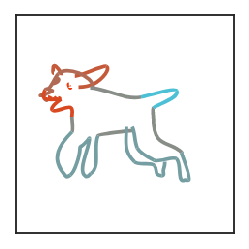

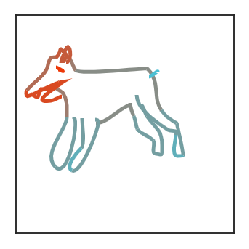

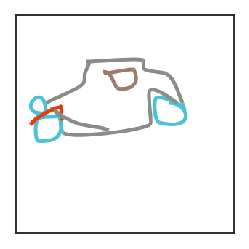

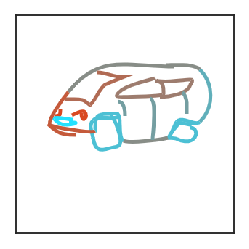

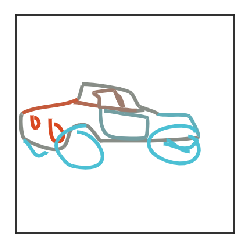

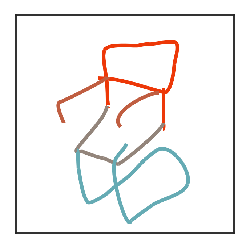

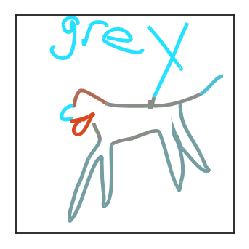

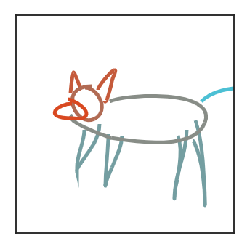

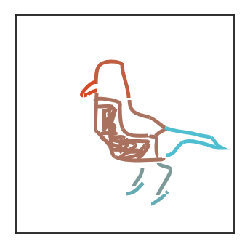

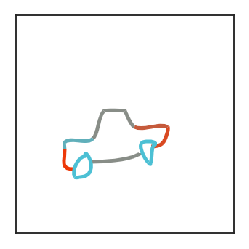

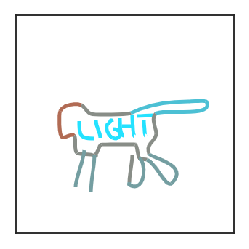

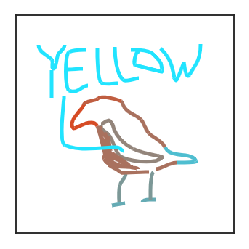

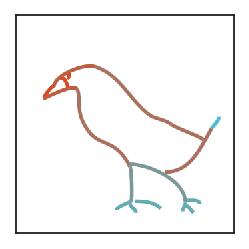

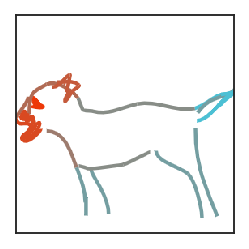

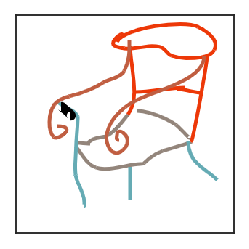

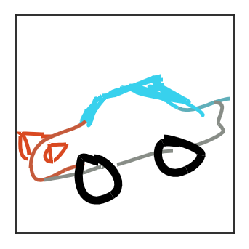

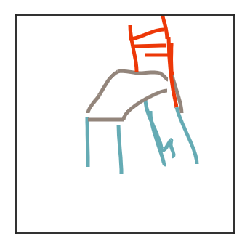

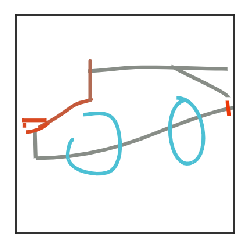

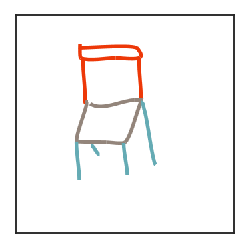

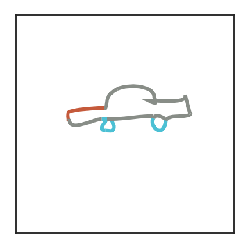

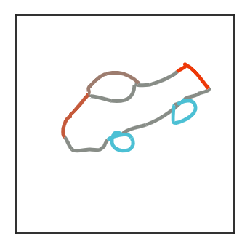

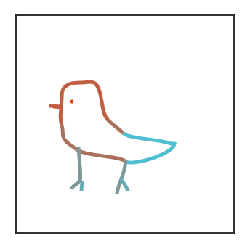

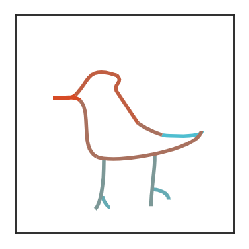

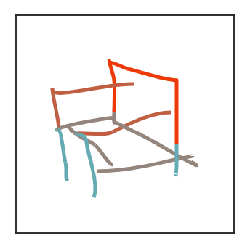

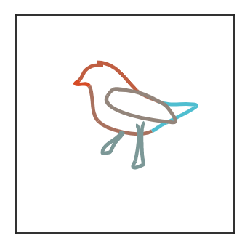

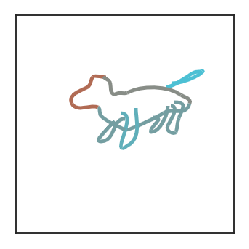

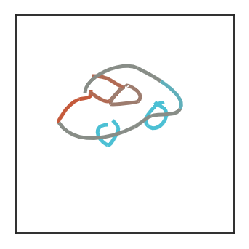

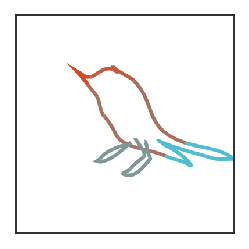

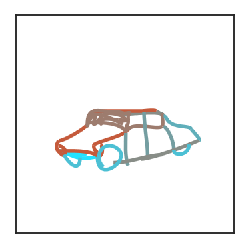

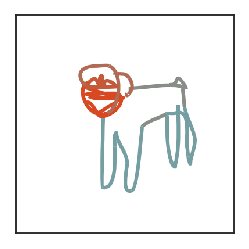

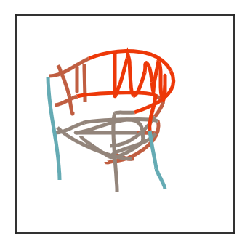

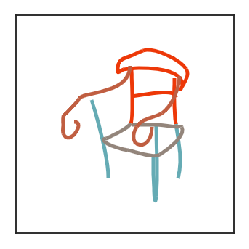

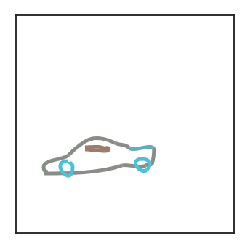

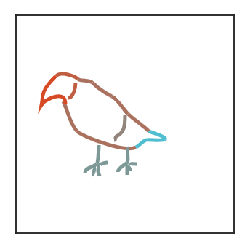

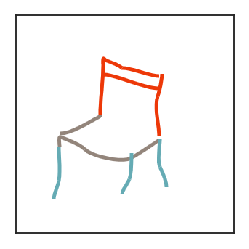

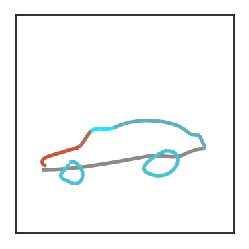

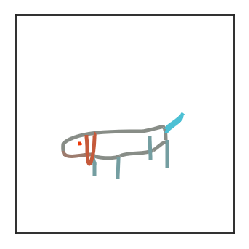

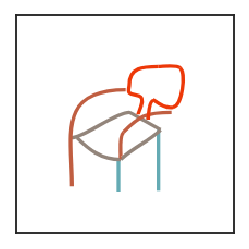

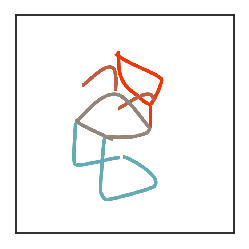

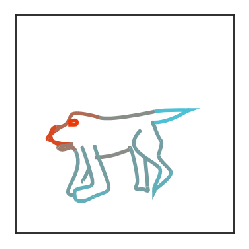

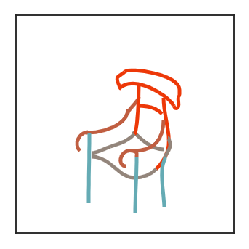

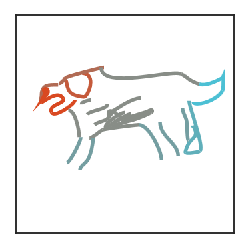

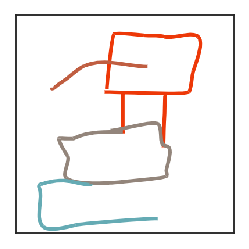

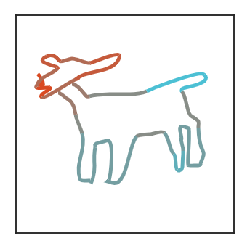

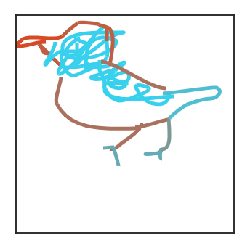

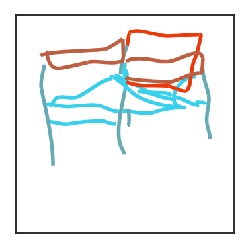

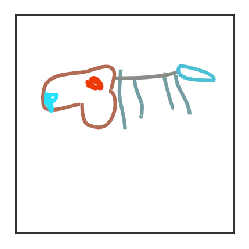

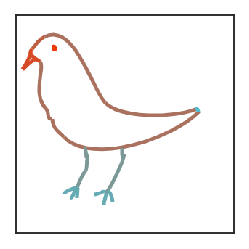

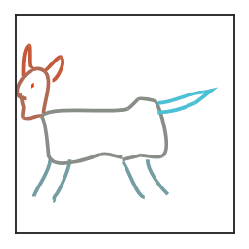

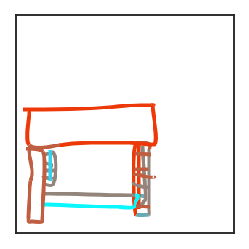

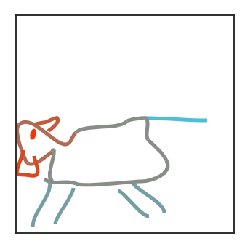

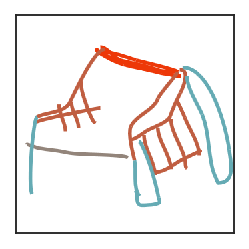

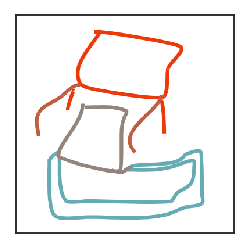

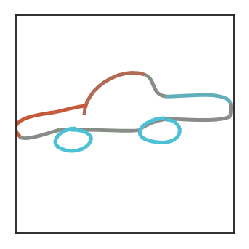

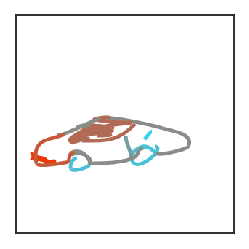

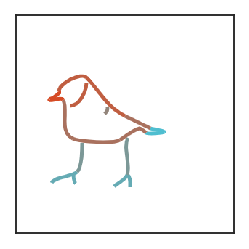

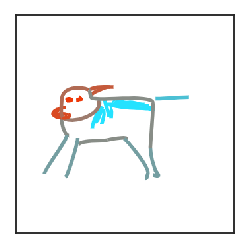

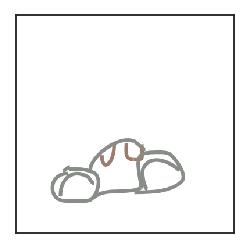

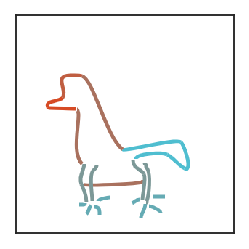

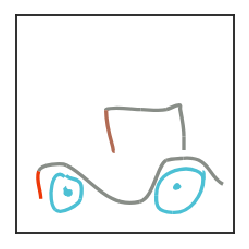

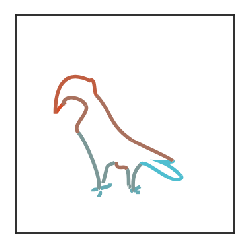

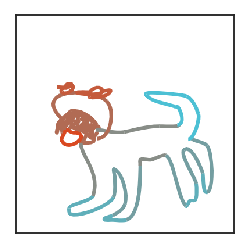

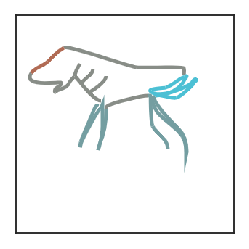

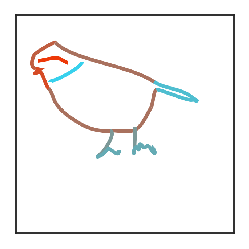

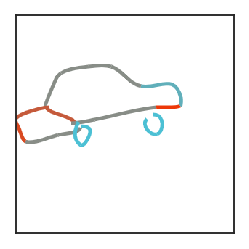

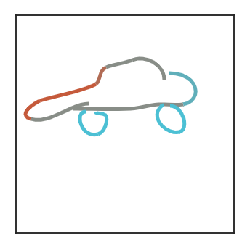

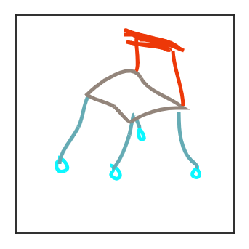

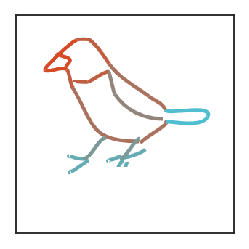

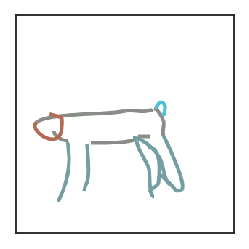

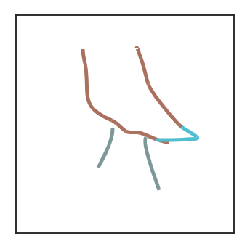

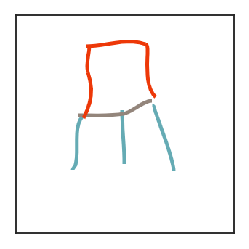

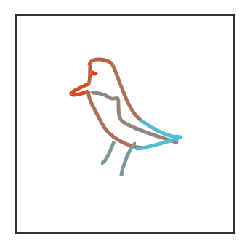

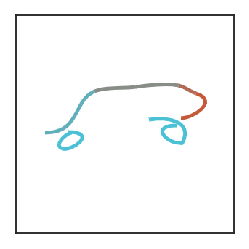

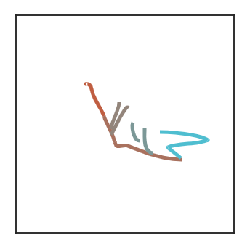

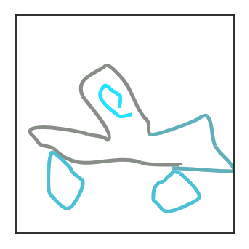

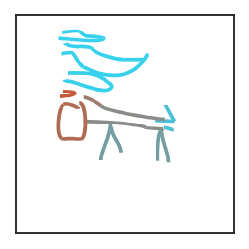

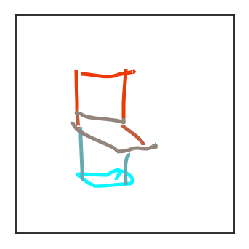

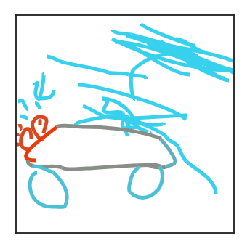

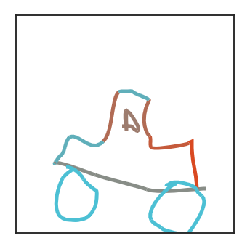

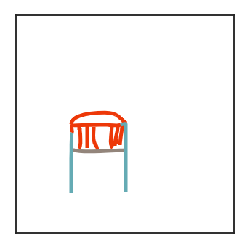

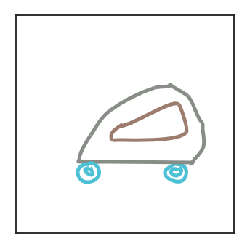

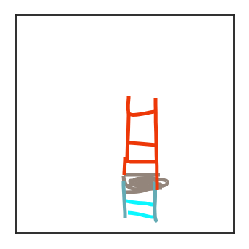

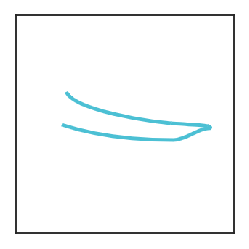

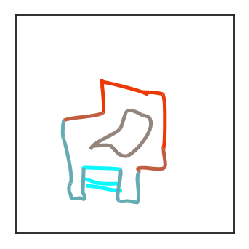

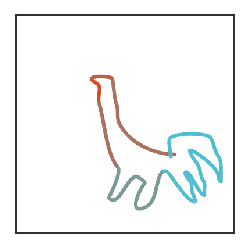

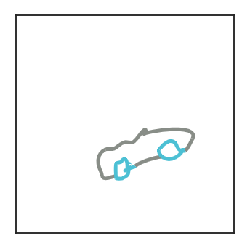

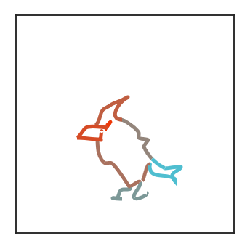

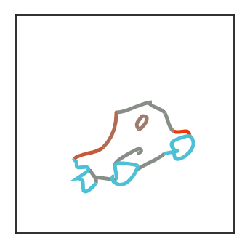

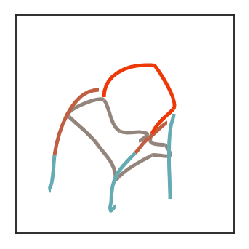

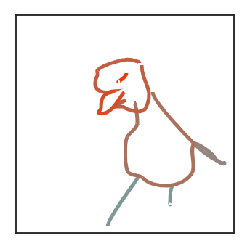

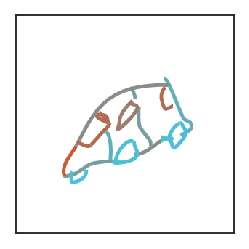

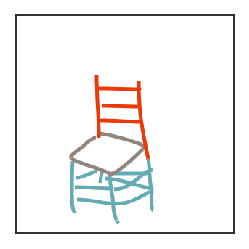

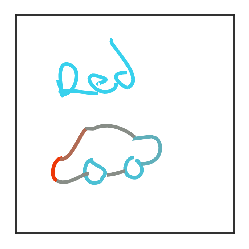

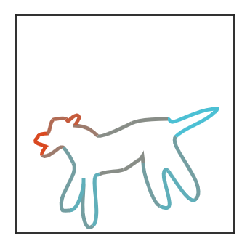

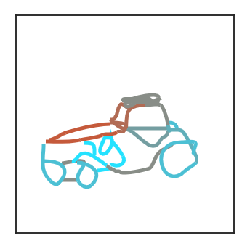

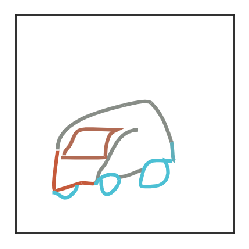

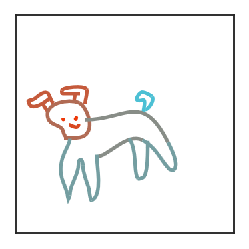

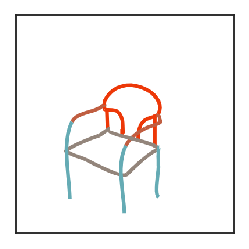

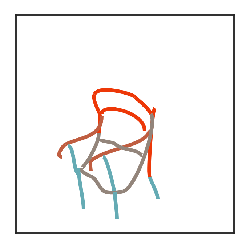

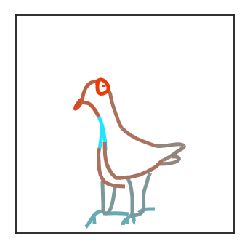

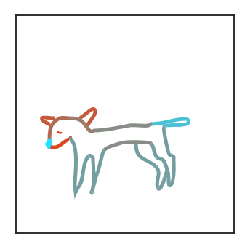

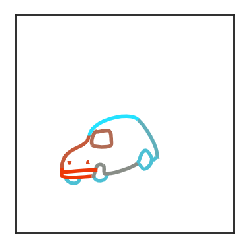

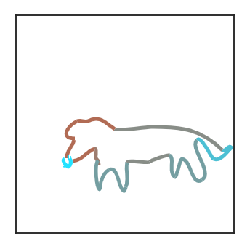

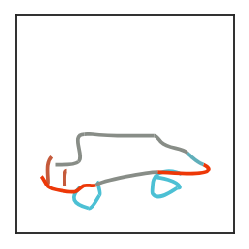

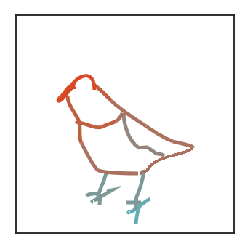

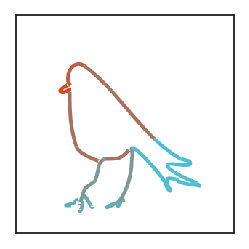

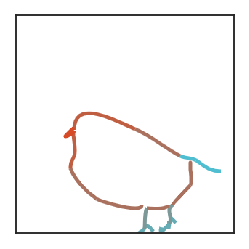

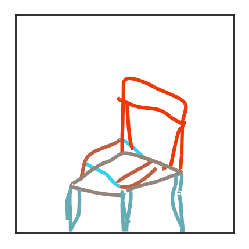

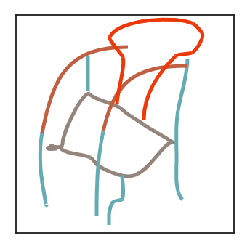

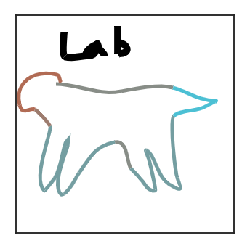

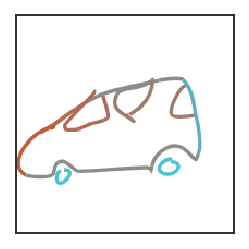

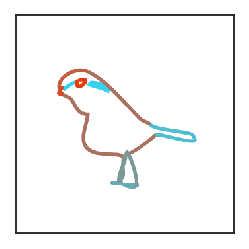

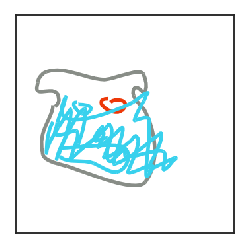

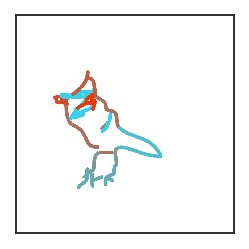

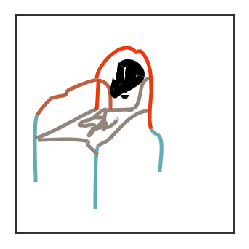

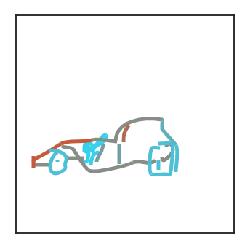

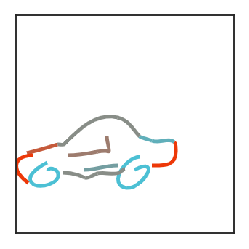

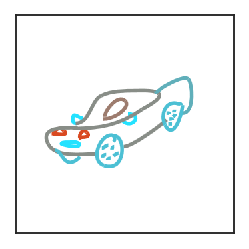

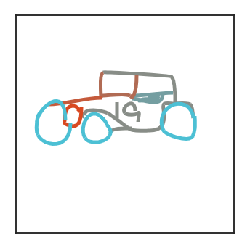

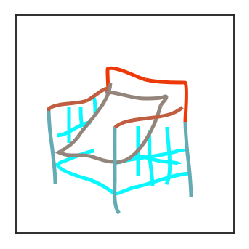

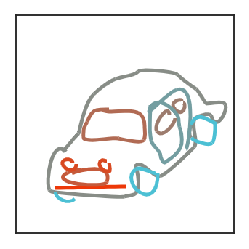

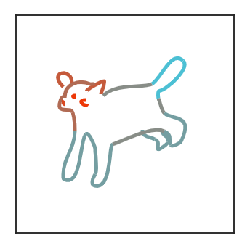

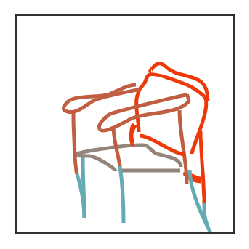

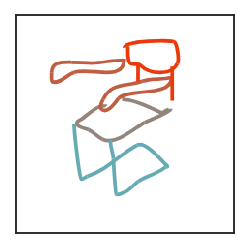

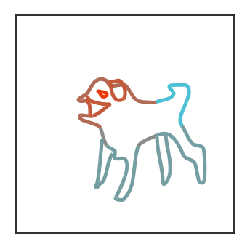

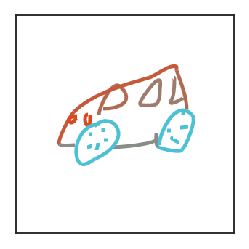

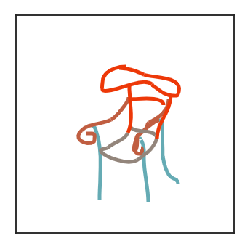

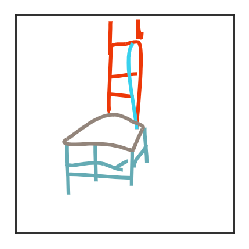

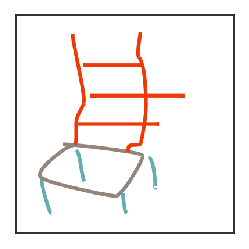

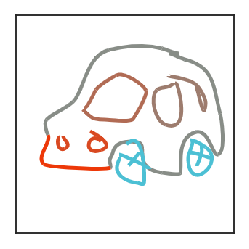

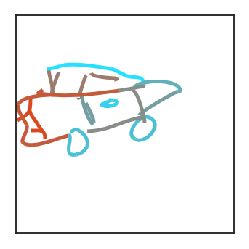

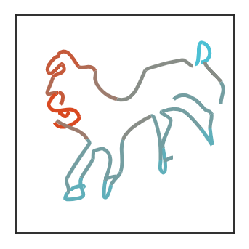

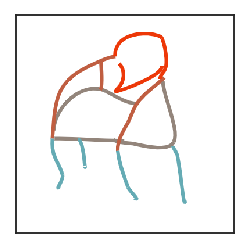

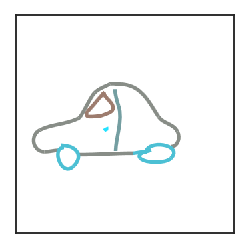

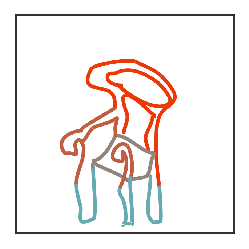

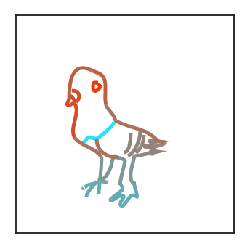

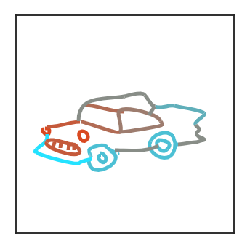

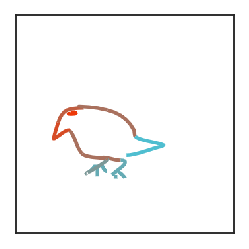

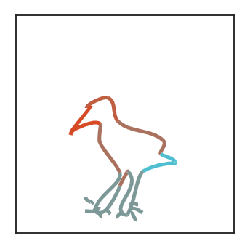

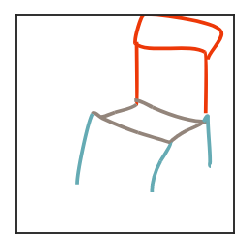

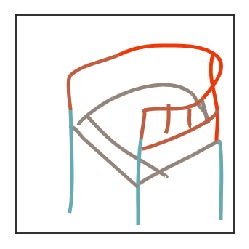

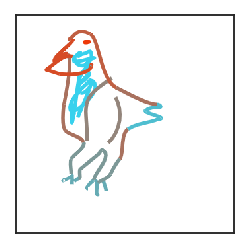

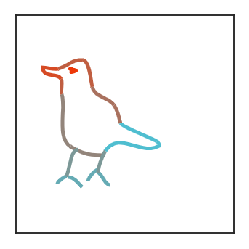

In [75]:
#Saving out the PNG for the sketches
from matplotlib.pyplot import imshow
import base64


#num_diff_annots = []
for this_sketch_id in unique_sketches:
    DS=D[D['sketch_id']==this_sketch_id]
    unique_splines = np.unique(DS['cumulative_spline_num'])
    for i,this_spline in enumerate(unique_splines):
        DSS =DS[DS['cumulative_spline_num']==this_spline]
        num_diff_annots= len(np.unique(DSS['label']))
    if num_diff_annots>0:  ##Will update this conditional once we have more annots
        for instance in np.unique(DS['annotation_id']):
                imgdata = base64.b64decode(DS[DS['annotation_id']==instance].iloc[0]['png'])
                filename = '{}_{}'.format(instance, DS[DS['annotation_id']==instance].iloc[0]['target'])  # I assume you have a way of picking unique filenames
                with open(filename, 'wb') as f:
                    f.write(imgdata)
                im = Image.open(filename)
                plt.figure()
                imshow(im)
                plt.xticks([])
                plt.yticks([])
                #plt.savefig(os.path.join(plot_dir,'{}_{}'.format(instance, DS[DS['annotation_id']==instance].iloc[0]['target'])),edgecolor='w',bbox_inches='tight')
    

In [76]:
##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby(['stroke_id']).agg(lambda x:x.value_counts().index[0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})



In [77]:
####Setting up for building transition matrices for each different category

from itertools import product as p

tm_dict={}
for category in unique_cats:
    stroke_df_s = stroke_df[stroke_df['category']==category]  
    num_uniq_labs = len(np.unique(stroke_df_s['label']))
    temp_array = np.zeros([num_uniq_labs*num_uniq_labs,2],dtype='|S50')
    ind=0
    for roll in p(stroke_df_s['label'].unique().tolist(), repeat = 2):
        temp_array[ind,]= roll
        ind+=1
    for sketch in stroke_df_s.sketch_id.unique():
        sketch_df= stroke_df_s[stroke_df_s.sketch_id==sketch]
        sketch_df['incr_stroke_num'] = sketch_df['stroke_num']+1
        tm_df=sketch_df.merge(sketch_df, right_on='stroke_num', left_on='incr_stroke_num', how='inner' )
        plot_matrix_x= tm_df.label_x.append(pd.Series(temp_array[:,0]))
        plot_matrix_y=tm_df.label_y.append(pd.Series(temp_array[:,1]))
        ct_df= pd.crosstab(plot_matrix_x, plot_matrix_y)-1
        #ct_df= pd.crosstab(tm_df.label_x, tm_df.label_y)
        mat= np.matrix(ct_df).sum()
        plot_df = ct_df.div(mat, axis=0).round(2)
        plot_df=plot_df.fillna(0)
        tm_dict[sketch]= plot_df


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


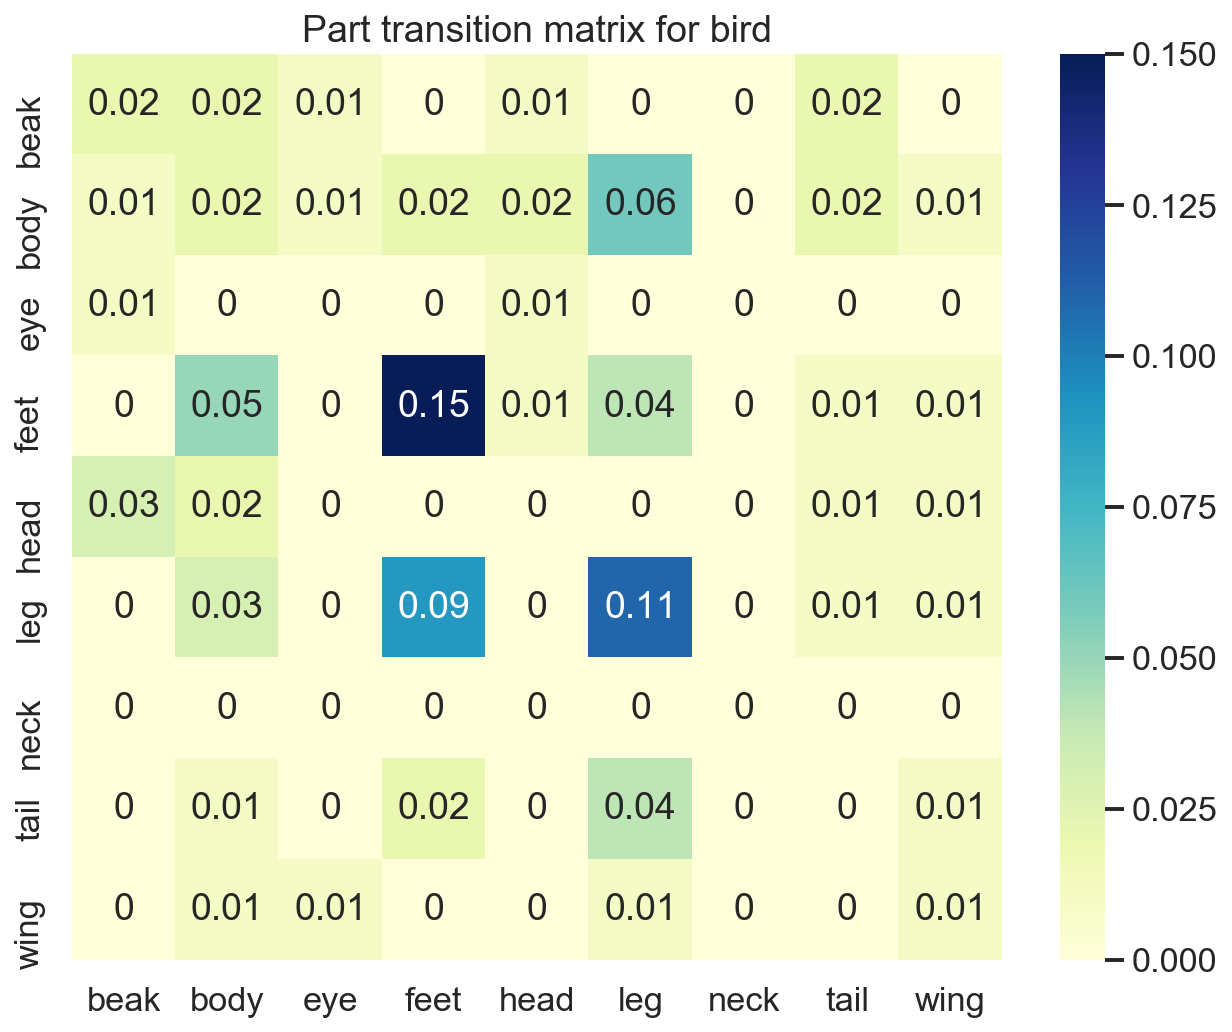

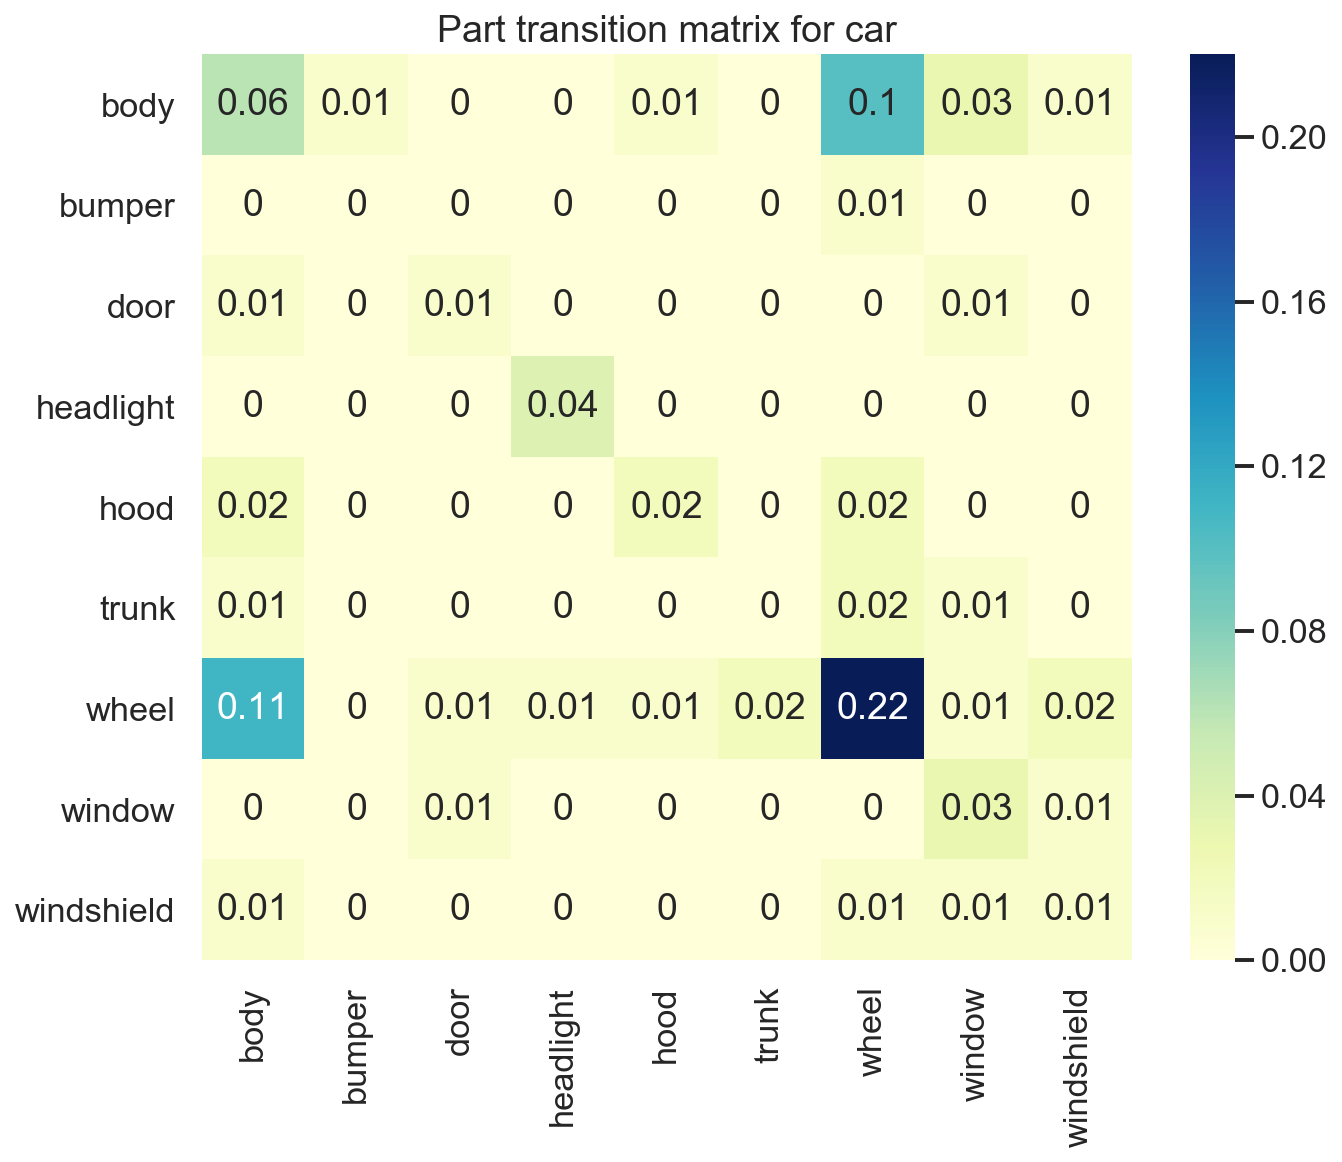

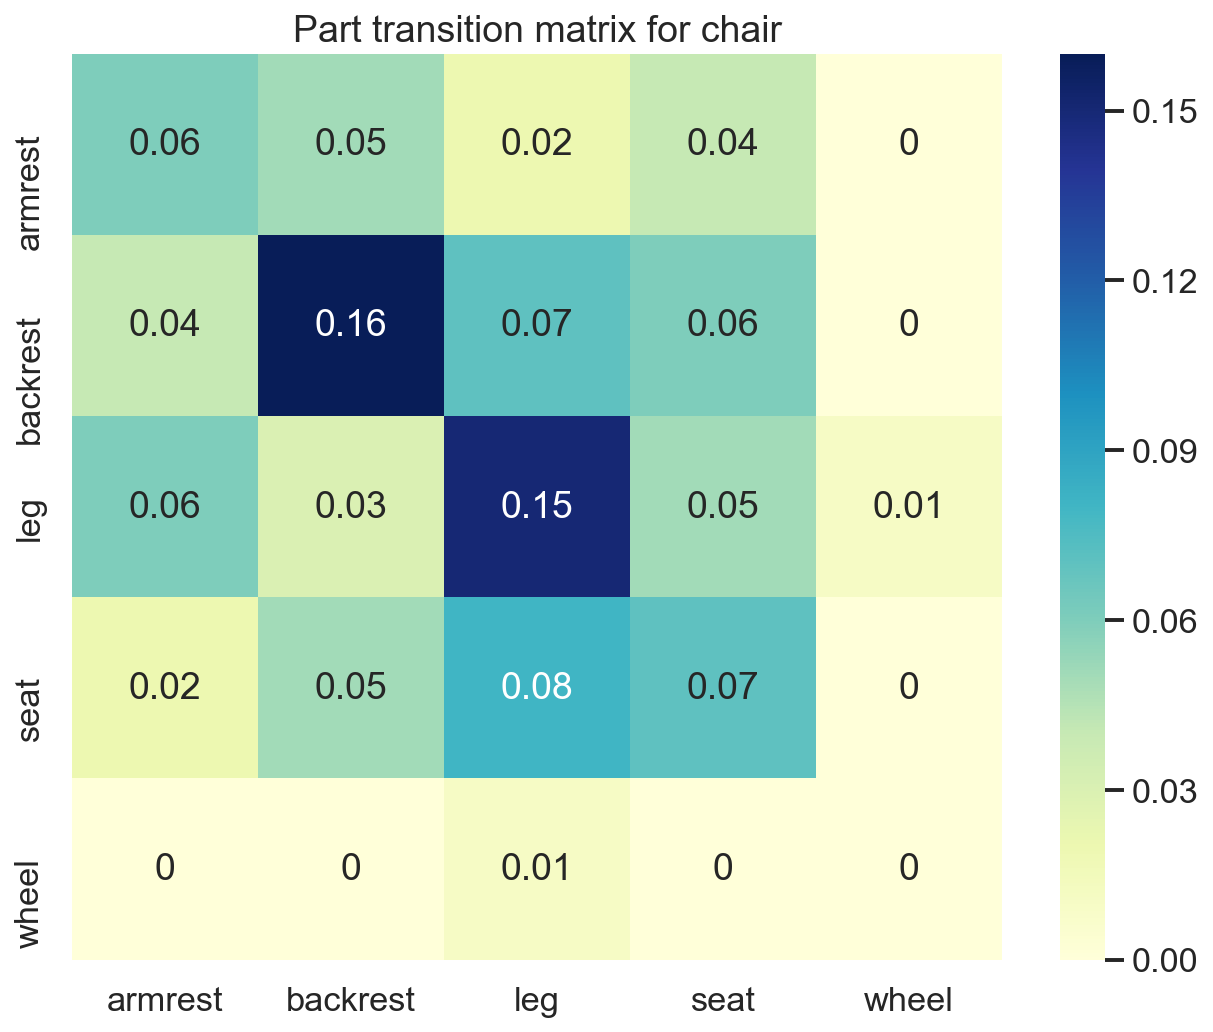

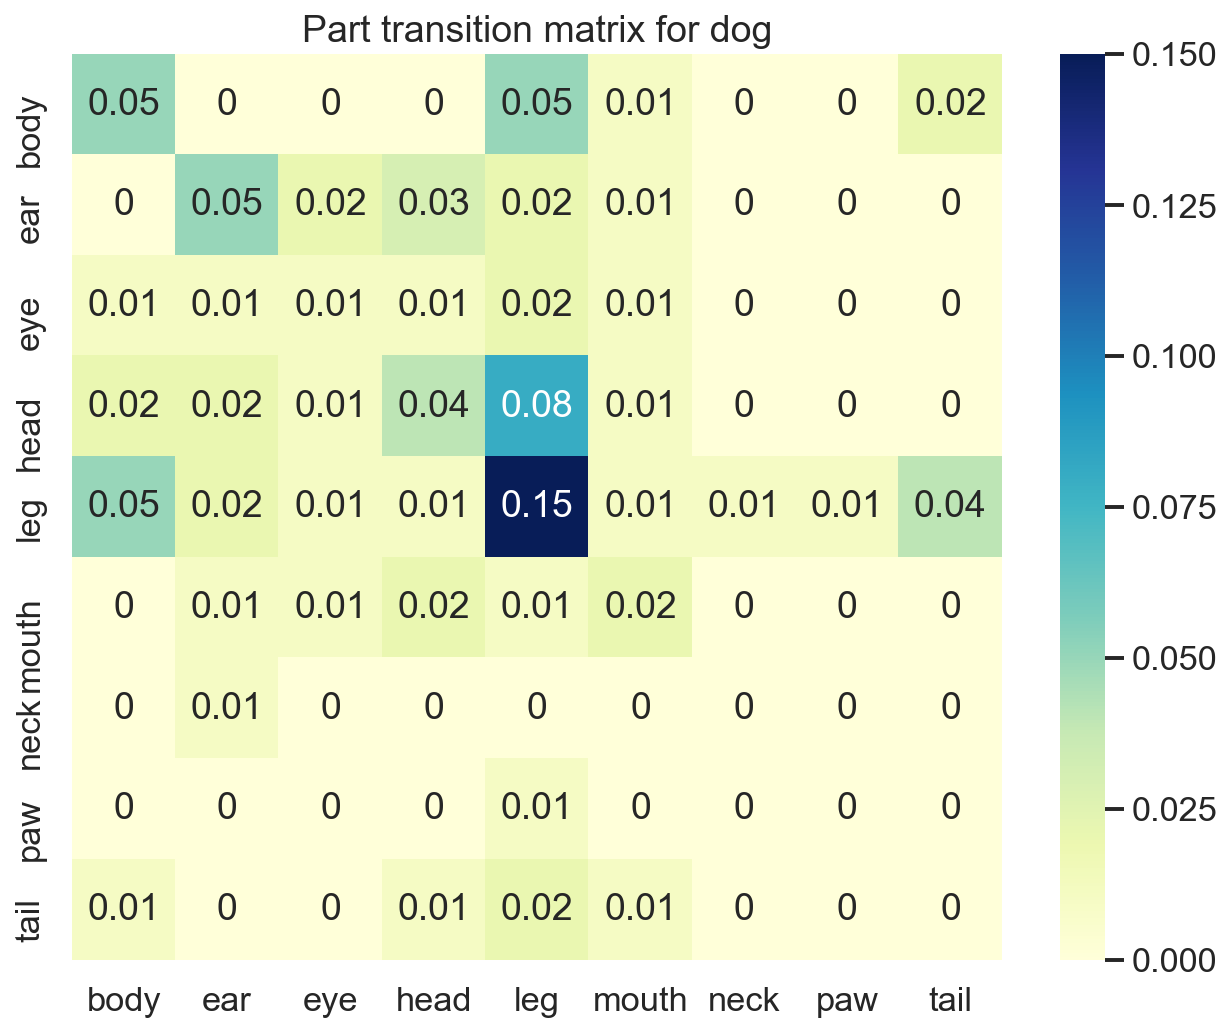

In [78]:
for category in unique_cats:
    cat_matrices=[]
    DS=D[D['category']==category]
    for sketch in DS['sketch_id'].unique():
        cat_matrices.append(tm_dict[sketch])
    fig,ax=plt.subplots(1, 1, figsize = (10, 8), dpi=150)
    agg_matrix= sum(cat_matrices)
    divider=np.matrix(agg_matrix).sum()
    agg_matrix = agg_matrix.div(divider, axis=0).round(2)
    sns.heatmap(agg_matrix,cmap="YlGnBu", annot=True)
    plt.title("Part transition matrix for {}".format(category))
    ax.set_ylabel('')    
    ax.set_xlabel('')


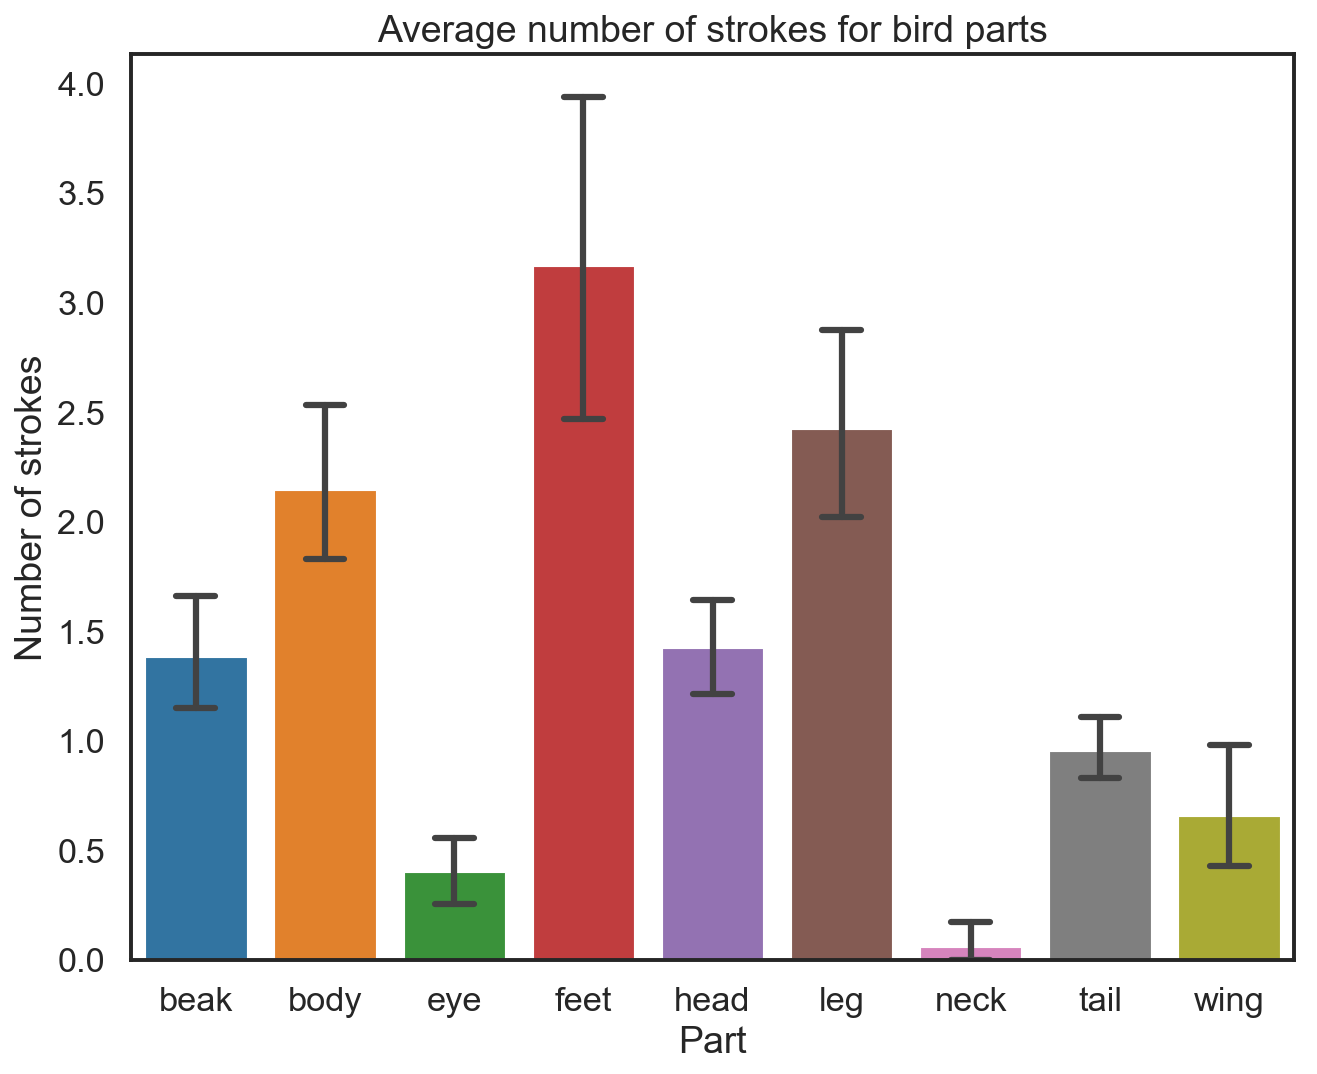

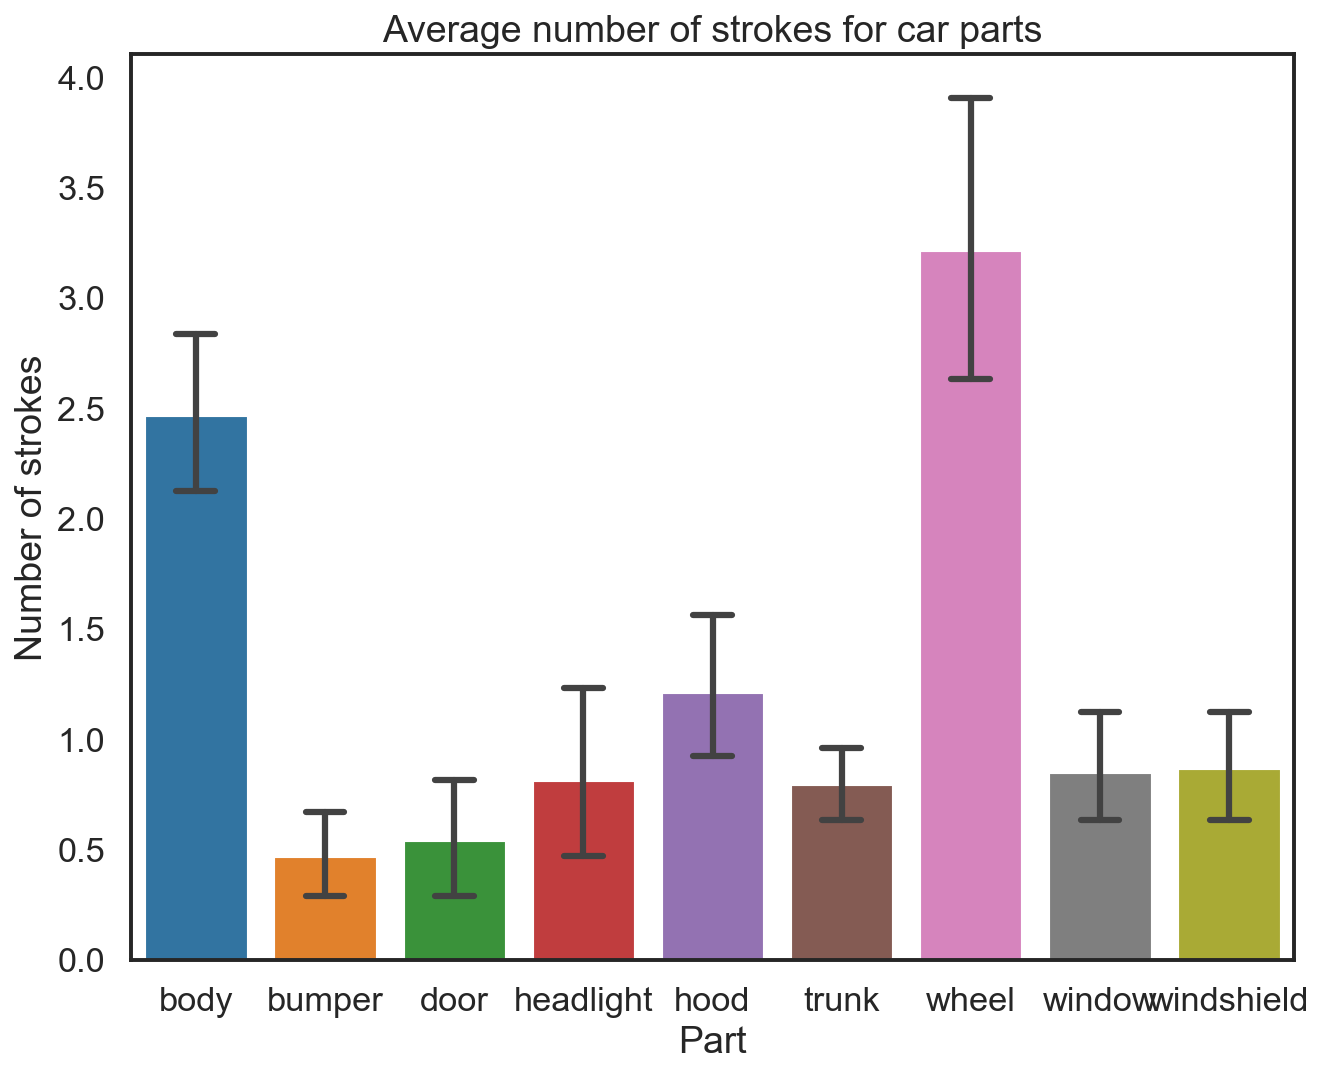

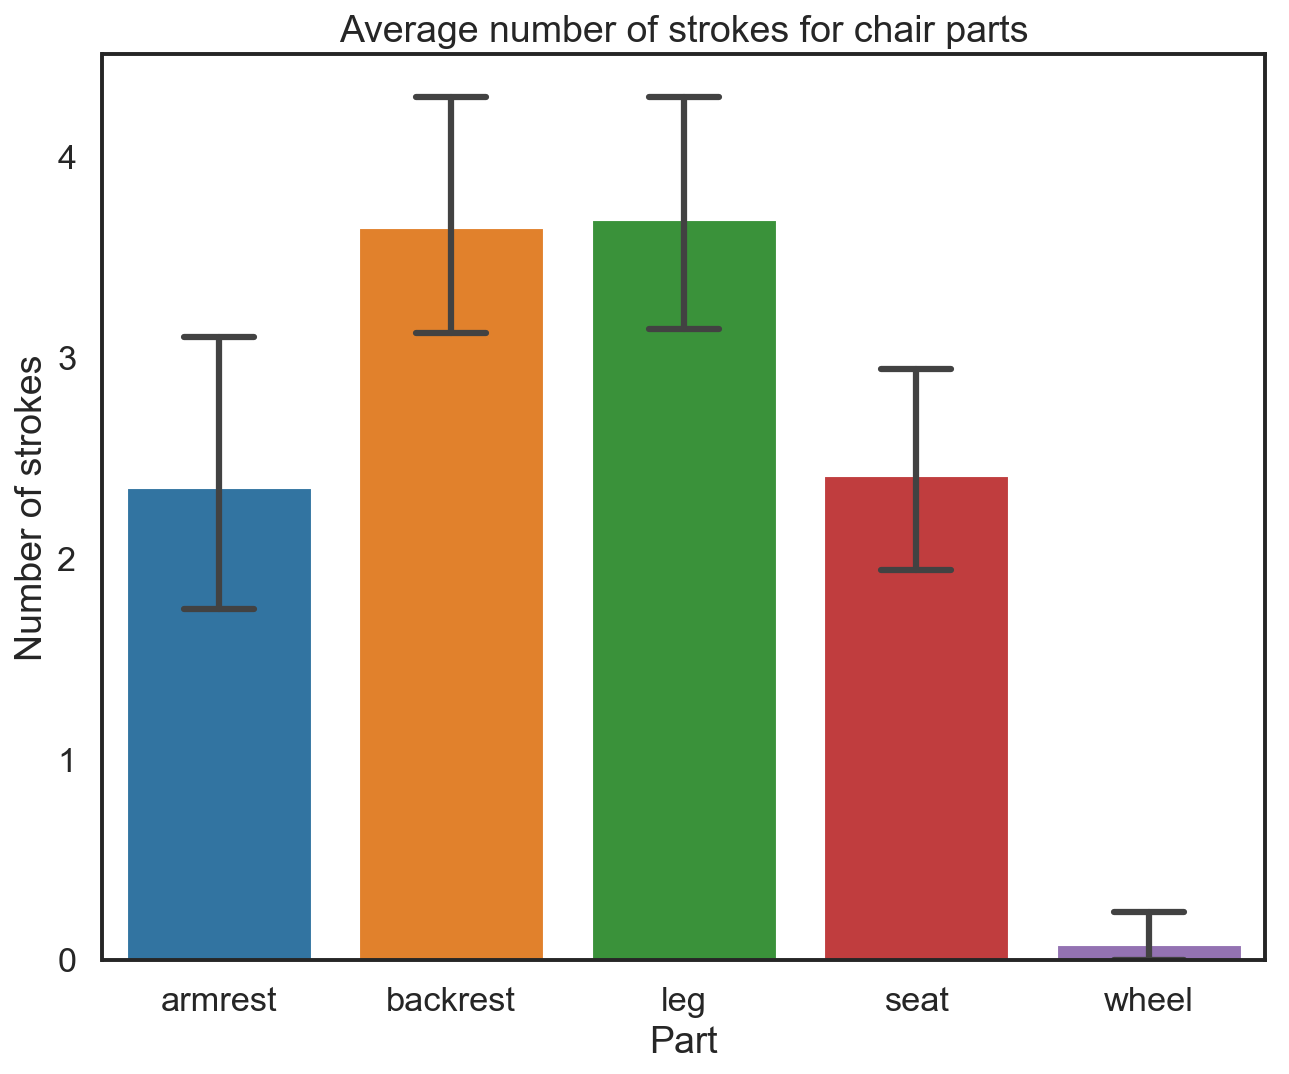

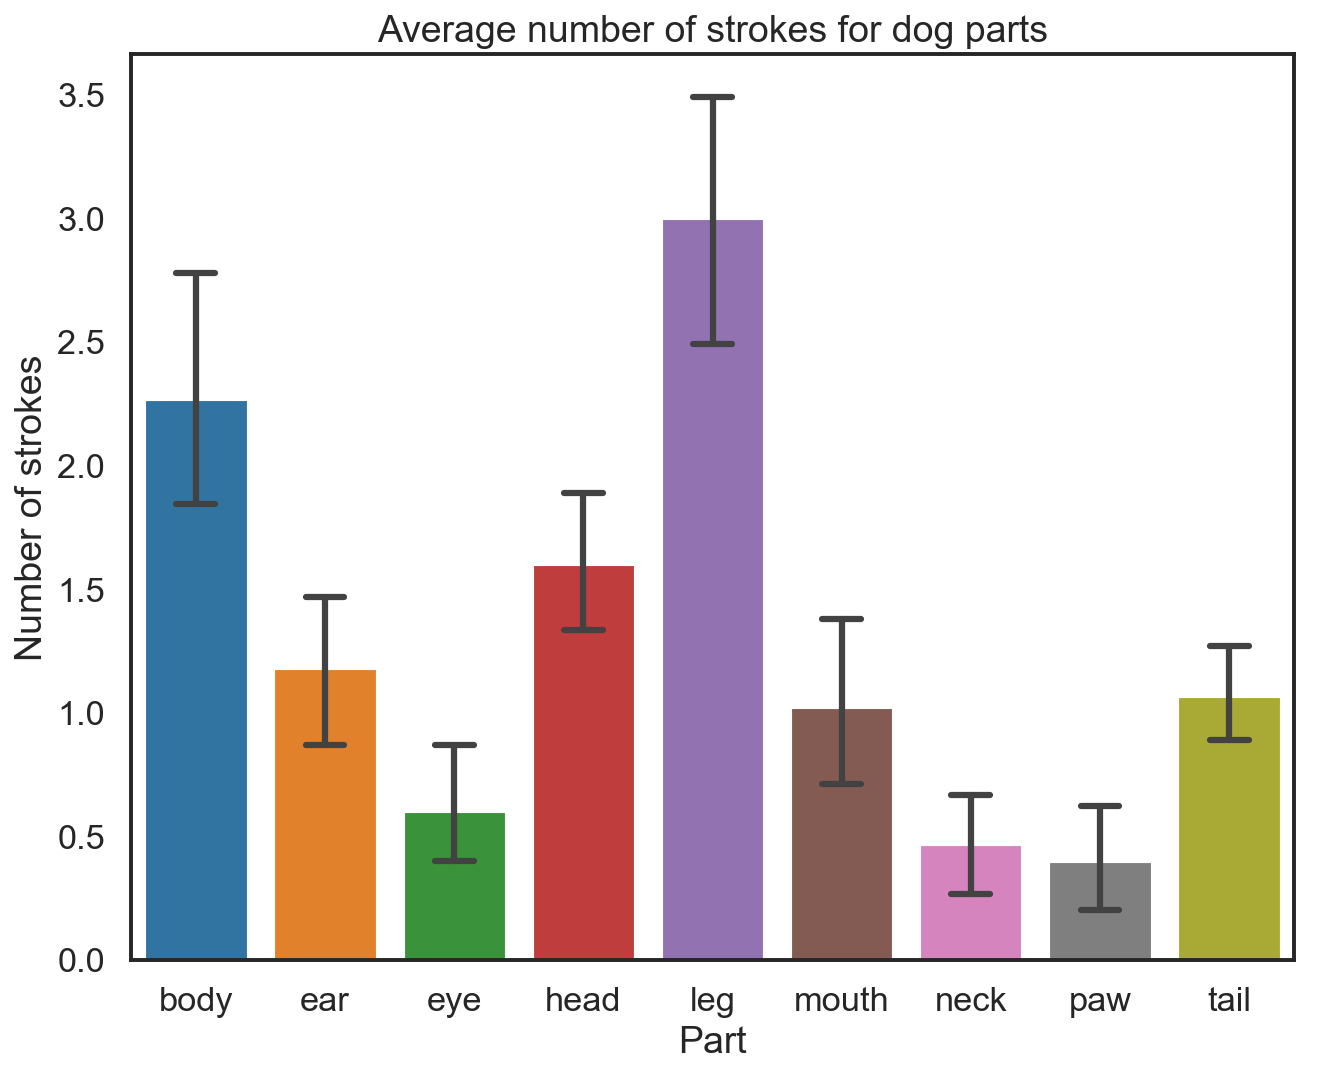

In [79]:
###Investigating how stroke length varies between parts given a category of objects 

for category in unique_cats:
    DS= D[D['category']==category]
    num_unique_labs = len(DS['label'].unique())
    strokes_in_part_vect = np.zeros((len(np.unique(DS['annotation_id']))*num_unique_labs,3), dtype='|a1000')
    ind=0
    for this_annotation in np.unique(DS['annotation_id']):    
        DSA= DS[DS['annotation_id']==this_annotation]
        for this_label in np.unique(DS['label']):
            DSB=DSA[DSA['label']==this_label]
            strokes_in_part_vect[ind,]=[this_annotation, this_label,len(np.unique(DSB['stroke_num']))]
            ind+=1
    strokes_in_part_vect=strokes_in_part_vect[~np.all(strokes_in_part_vect == '', axis=1)]
    strokes_in_part_df= pd.DataFrame(strokes_in_part_vect, columns=['annotation_id','part','num_strokes'])
    strokes_in_part_df['num_strokes']=pd.to_numeric(strokes_in_part_df['num_strokes'])
    fig,ax=plt.subplots(1, 1, figsize = (10, 8), dpi=150)
    sns.barplot(x='part',y='num_strokes',data=strokes_in_part_df,ci=95,capsize=0.3, errwidth= 3)
    plt.title('Average number of strokes for {} parts'.format(category))
    plt.ylabel('Number of strokes')
    plt.xlabel('Part')


In [80]:
from svgpathtools import parse_path
import svgpathtools


In [81]:
stroke_df['arc_length'] = ""
for s,stroke in stroke_df.iterrows():
    stroke_df['arc_length'][s] = parse_path(stroke['svg']).length()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


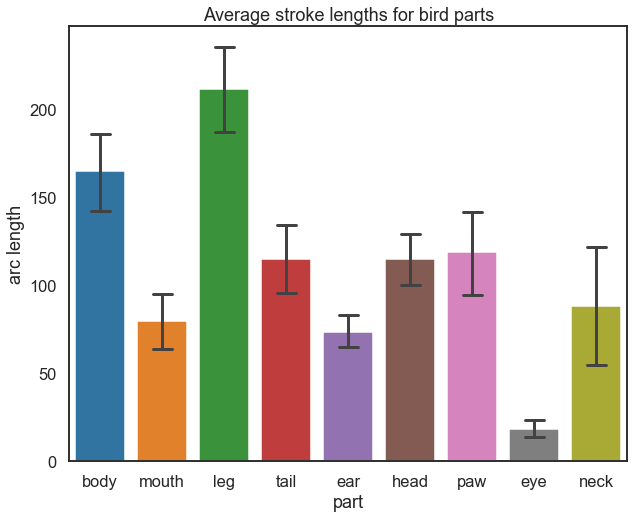

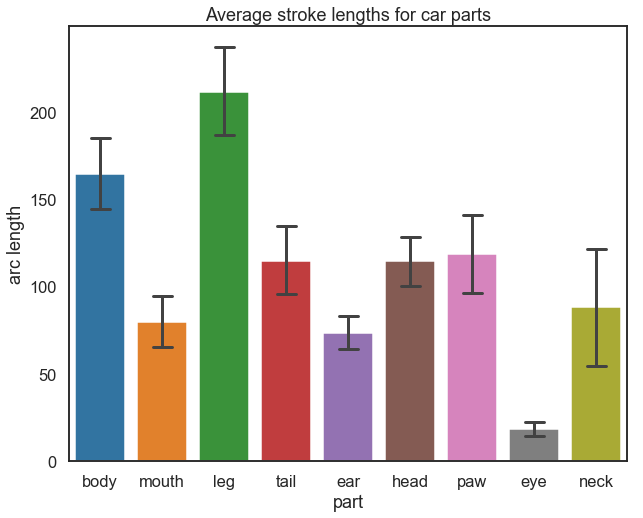

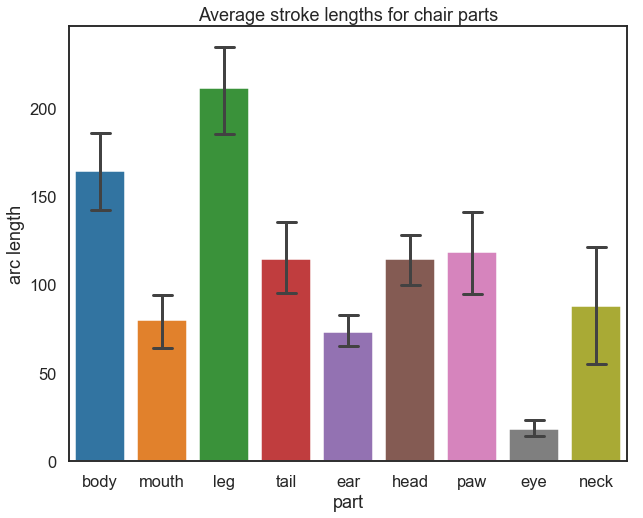

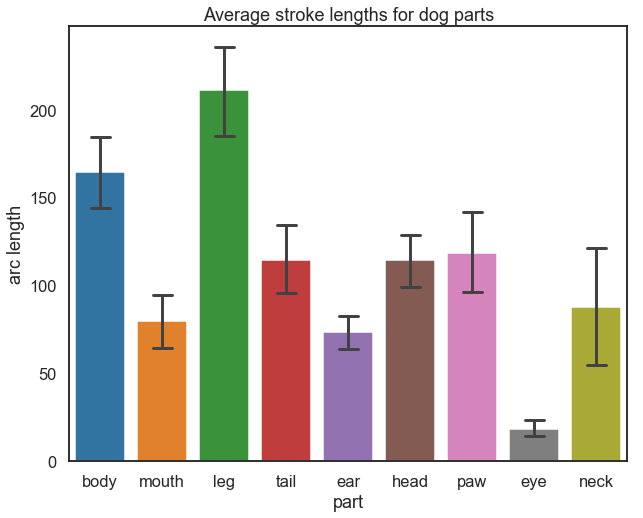

In [82]:
##Investigating how arc length varies between parts

for category in unique_cats:
    plt.figure(figsize=(10,8))
    sns.barplot(x='label', y='arc_length', data=stroke_df[stroke_df['category']=='dog'], ci=68,capsize=0.3, errwidth= 3)
    plt.title('Average stroke lengths for {} parts'.format(category))
    plt.ylabel('arc length')
    plt.xlabel('part')

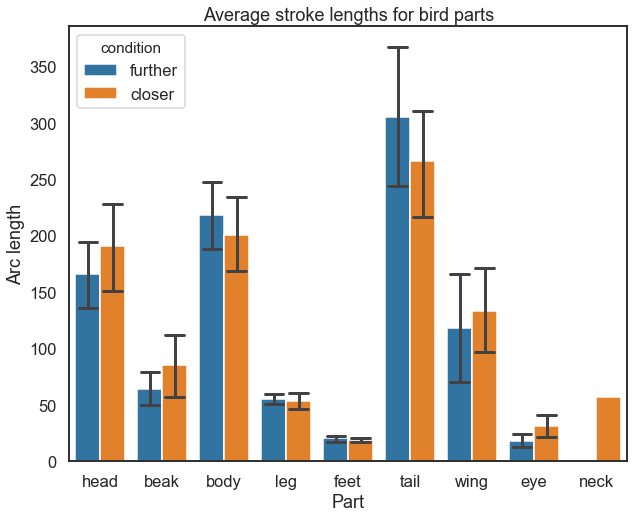

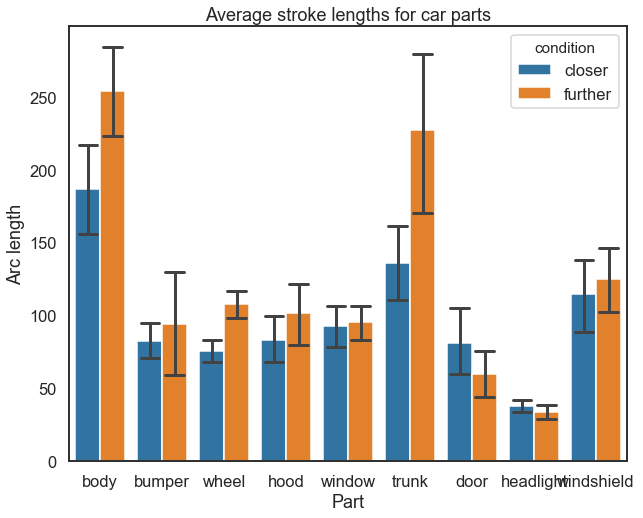

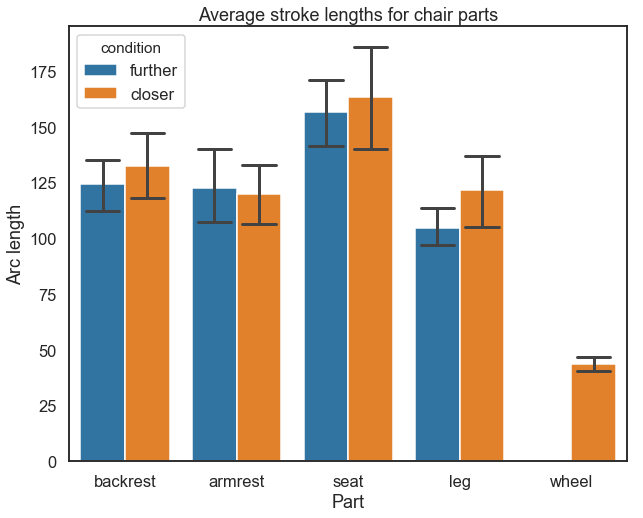

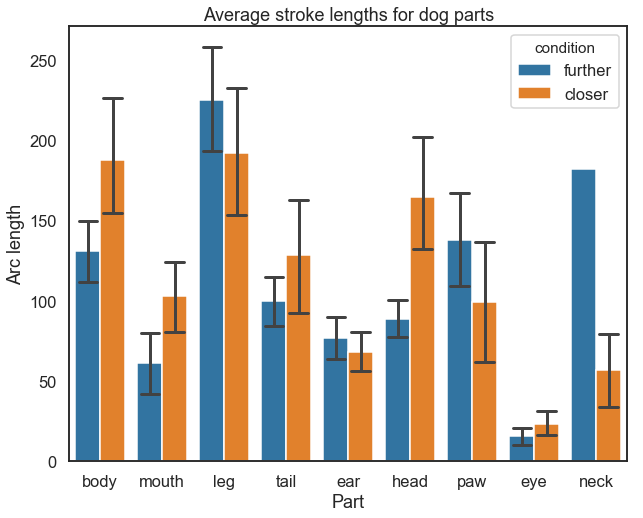

In [83]:
###Investigating how arc length varies between parts x conditions

for category in unique_cats:
    plt.figure(figsize=(10,8))
    sns.barplot(x='label',y='arc_length',hue='condition', data=stroke_df[stroke_df['category']==category],ci=68,capsize=0.3, errwidth= 3)
    plt.title('Average stroke lengths for {} parts'.format(category))
    plt.ylabel('Arc length')
    plt.xlabel('Part')

In [84]:
###Might Delete this - calculating average arc length per part manually####
part_lengths={}
for category in unique_cats:
    stroke_df_lite= stroke_df[stroke_df['category']==category]
    arc_length_dict = OrderedDict()
    for label in np.unique(stroke_df_lite['label']):
        stroke_df_lite0= stroke_df_lite[stroke_df_lite['label']==label]
        path_length=0
        for stroke in np.unique(stroke_df_lite0['stroke_id']):
            path = parse_path(stroke_df_lite0[stroke_df_lite['stroke_id']==stroke]['svg'].iloc[0])
            path_length= path_length+path.length()
        arc_length_dict[label]= path_length/len(stroke_df_lite0)
    part_lengths[category]=arc_length_dict


    
    

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
### Investigating the number of parts for each part within a category. Does this number correspond to number 
###of strokes with that part label?

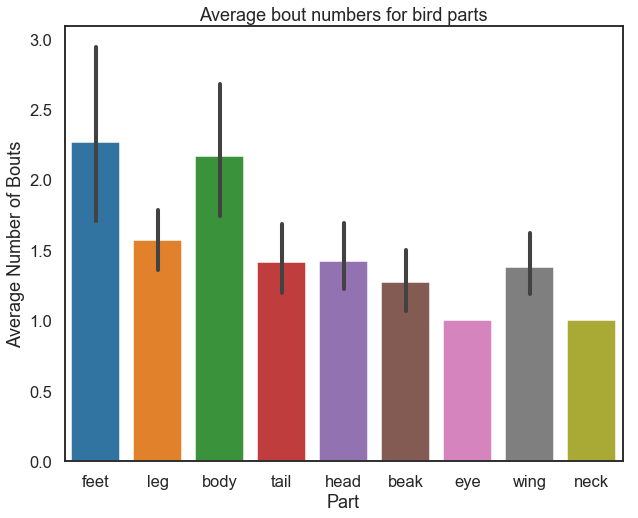

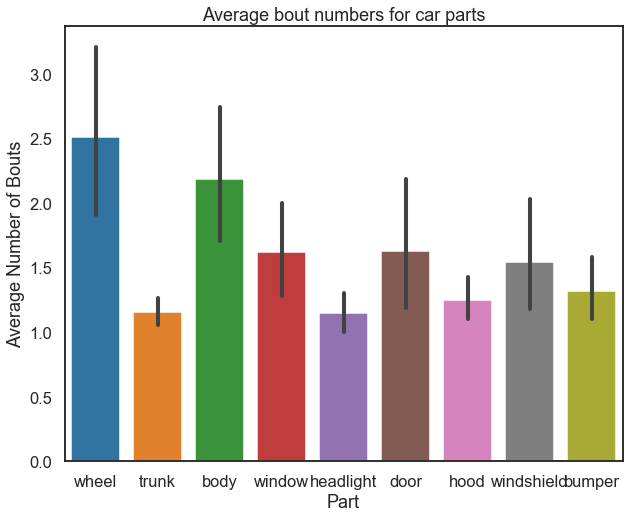

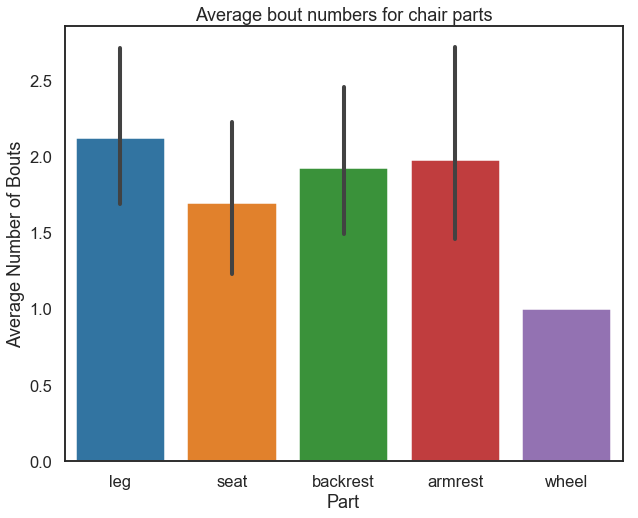

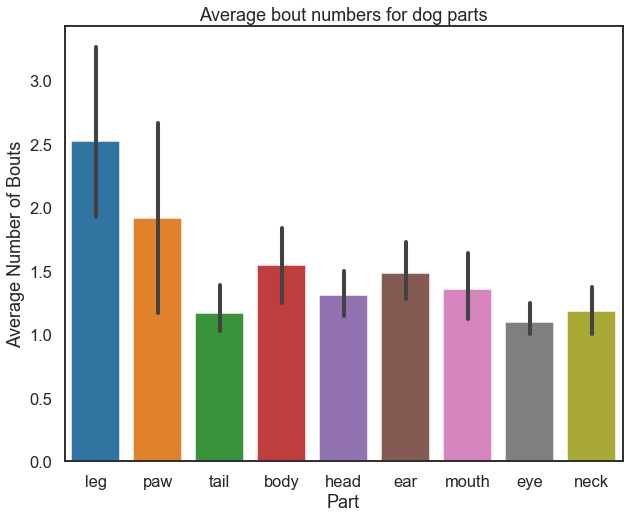

In [130]:
D['part_bout_num'] = pd.to_numeric(D['part_bout_num'])

for category in unique_cats:
    DS=D[D['category']==category]
    unique_labels_in_cat= DS['label'].unique()
    plot_vect = np.zeros([1,2], dtype='|a20')
    for label in unique_labels_in_cat:
        DSA=DS[DS['label']==label]
        total_bouts=0
        for sketch in DSA['sketch_id'].unique():
            DSB= DSA[DSA['sketch_id']==sketch]
            num_bouts = len(DSB['part_bout_num'].unique())
            temp= np.array([label, num_bouts], dtype= '|a20')
            plot_vect=np.vstack((plot_vect, temp))
    plot_vect=np.delete(plot_vect, (0), axis=0)  
    plot_df= pd.DataFrame(plot_vect, columns=['label','num_bouts'])
    plot_df['num_bouts']=pd.to_numeric(plot_df['num_bouts'])
    plt.figure(figsize=(10,8))
    sns.barplot(x='label',y='num_bouts',data= plot_df)
    plt.title('Average bout numbers for {} parts'.format(category))
    plt.ylabel('Average Number of Bouts')
    plt.xlabel('Part')

        #label_group_data=DS.groupby('label').agg({'part_bout_num':"mean"})
    